# Final Project

Team members: Paul Witczak, Filip Janeba, Jasmine Dressler, Sara Tamanza

# Who we are
We’re FinDev’s data science partner. FinDev builds financial software for B2B clients and wants to turn LinkedIn into a steady pipeline for awareness and qualified conversations. 
Our mandate: use the historical LinkedIn post data to find the few controllable levers that reliably lift engagement, and turn that into a practical posting playbook.
Our dataset includes 31 000 posts, each containing information about the post’s content, format, publication time, engagement metrics, and contextual data about the publisher (such as country, industry, and number of followers).


### The business challenge
- FinDev’s posts get inconsistent traction; standout posts coexist with many quiet ones.
- Leadership wants a repeatable way to reach the right buyers more often, without guessing formats or timing.
- Success means higher engagement (Likes + Comments + Shares).

### Structure of this Document

In this document we 

1. Preprocess/clean our data
2. Perform basic statistics and an exploratory data analysis
3. Try to find the best working model
4. Keep the best model and tune it
5. Analyze the feature importance
6. Give business recommendations
7. Show model performance plots 

## 1. Preprocessing and data cleaning

### Loading data, importing libraries, and overview of the data set

In [1]:
# To start, we import all necessary libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Next, we import model-selection utilites, estimators, preprocessing transformers 
# and evaluation metrics
# These will help us later on, while finding the best model for our data set 

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, roc_auc_score, f1_score, cohen_kappa_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE #pip install imbalanced-learn
from sklearn.cluster import KMeans
import xgboost as xgb #pip install xgboost
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from scipy.spatial import distance

In [4]:
# To ensure that the visualizations throughout the notebook look clean, we define consistent and aesthetically pleasing 
# defaults for all of our plots in this notebook, so we do not have to repeat this later on

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

In [5]:
# Now we start by reading our data
# To get an overview of what our data set looks like, we are displaying the first 5 rows

df = pd.read_csv("./data/linkedin.csv", sep=";")
print(f"Data loaded successfully: {df.shape[0]:,} posts with {df.shape[1]} features")
df.head()

Data loaded successfully: 31,020 posts with 19 features


,entity_id,post_type,followers,industry,location,post_id,format,post_date,post_day,post_hour,likes,comments,shares,num_sentences,company_mentions_count,profile_mentions_count,hashtags_count,external_links_count,processed
0,2,company,15157,Financial Services,United States,1,Image,2025-09-25T00:00:00+00:00,Thursday,15:00,19,1,2,7,0,0,0,0,True
1,2,company,15157,Financial Services,United States,2,Video,2025-09-23T00:00:00+00:00,Tuesday,15:00,38,1,3,5,1,1,0,1,True
2,2,company,15157,Financial Services,United States,3,Image,2025-09-18T00:00:00+00:00,Thursday,15:00,46,2,8,7,1,4,0,1,True
3,2,company,15157,Financial Services,United States,4,Document,2025-09-16T00:00:00+00:00,Tuesday,14:35,30,1,3,3,0,0,0,0,True
4,2,company,15157,Financial Services,United States,5,Image,2025-09-11T00:00:00+00:00,Thursday,15:00,32,1,3,3,1,2,0,0,True


In [6]:
# Displaying the info to find out the column names and their data type

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31020 entries, 0 to 31019
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   entity_id               31020 non-null  int64 
 1   post_type               31020 non-null  object
 2   followers               31020 non-null  int64 
 3   industry                31020 non-null  object
 4   location                31020 non-null  object
 5   post_id                 31020 non-null  int64 
 6   format                  31020 non-null  object
 7   post_date               31020 non-null  object
 8   post_day                31020 non-null  object
 9   post_hour               31020 non-null  object
 10  likes                   31020 non-null  int64 
 11  comments                31020 non-null  int64 
 12  shares                  31020 non-null  int64 
 13  num_sentences           31020 non-null  int64 
 14  company_mentions_count  31020 non-null  int64 
 15  pr

In [7]:
# Here we display descriptive statistics from our quantitative data

df.describe().T

,count,mean,std,min,25%,50%,75%,max
entity_id,31020.0,5.967056e+02,1.559828e+03,1.0,49.00,91.0,125.00,9955.0
followers,31020.0,1.153048e+06,4.066597e+06,0.0,8644.00,35323.0,330825.00,26494757.0
post_id,31020.0,1.810272e+04,1.038567e+04,1.0,8829.75,18645.5,27087.25,35322.0
likes,31020.0,1.352301e+02,1.021438e+03,0.0,10.00,28.0,84.00,128071.0
comments,31020.0,5.821728e+00,3.610454e+01,0.0,0.00,1.0,3.00,3649.0
shares,31020.0,9.051322e+00,8.465799e+01,0.0,0.00,2.0,6.00,11207.0
num_sentences,31020.0,5.519052e+00,3.754816e+00,0.0,3.00,5.0,7.00,48.0
company_mentions_count,31020.0,9.344939e-01,2.055085e+00,0.0,0.00,0.0,1.00,40.0
profile_mentions_count,31020.0,8.651515e-01,2.179987e+00,0.0,0.00,0.0,1.00,40.0
hashtags_count,31020.0,1.841779e+00,2.902643e+00,0.0,0.00,0.0,3.00,39.0


In [8]:
# To get an overview of our data set, we are displaying the shape, the range, missing values and duplicate records

print("\nDATASET OVERVIEW")
print("-" * 30)
print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['post_date'].min()} to {df['post_date'].max()}")
print(f"Missing values: {df.isnull().sum().sum()}")
print(f"Duplicate records: {df.duplicated().sum()}")


DATASET OVERVIEW
------------------------------
Dataset shape: (31020, 19)
Date range: 2013-10-31T00:00:00+00:00 to 2025-10-01T00:00:00+00:00
Missing values: 0
Duplicate records: 0


### Preprocessing

In [9]:
# To ensure that nothing is lost, we will work with the copy of our data frame

data = df.copy()

In [10]:
# An important part of this preprocessing is ensuring a consistency of the posting date. Data has been collected from many
# different countries all around the world. To ensure that this does not lead to confusion later on when we try to find 
# the best posting time, certain measures have to be taken. 

# First, we have to ensured that the column "post_date" is being recognized as a date instead of a string

data['post_date'] = pd.to_datetime(data['post_date'])

# Then we check the unique values in the location column
location_counts = data['location'].value_counts()
print(location_counts)


location
United States           21292
United Kingdom           6747
Singapore                 654
France                    465
Netherlands               291
China                     288
Canada                    239
Poland                    219
India                     218
Cayman Islands            207
Switzerland               142
Australia                 133
United Arab Emirates       62
Ireland                    17
Norway                     17
South Africa               15
Denmark                    10
Indonesia                   4
Name: count, dtype: int64


In [11]:
# Next, we do a time zone conversion by first creating a dictionary of time zone offsets

location_offsets = {
    'United States': -5, 'United Kingdom': 0, 'Singapore': 8, 'France': 1,
    'Netherlands': 1, 'China': 8, 'Canada': -5, 'Poland': 1, 'India': 5.5,
    'Cayman Islands': -5, 'Switzerland': 1, 'Australia': 10,
    'United Arab Emirates': 4, 'Ireland': 0, 'Norway': 1, 'South Africa': 2,
    'Denmark': 1, 'Indonesia': 7
}

# Then, we map each post's location to its time zone offset 
# This will create a new column called "timezone_offset" containing the numeric time differences

data['timezone_offset'] = data['location'].map(location_offsets).fillna(0)

In [12]:
# The data in "post_hour" is currently a string that looks like this: "12:00" 

# To make it easier to work with we are splitting the data at the colon (:), only keeping the hour and converting it to an int
# Creating the new column "post_hour_numeric"

data['post_hour_numeric'] = data['post_hour'].str.split(':').str[0].astype(int)

# Since we want to keep also the minutes we are doing the same but this time only keeping the data after the colon (:), 
# so only the minutes, also converting it to an integer
# We put the result into the new column "post_minute_numeric"

data['post_minute_numeric'] = data['post_hour'].str.split(':').str[1].astype(int)

# To avoid missing values, in case a time was only recorded like this "12", we fill them with 0

data['post_minute_numeric'] = data['post_minute_numeric'].fillna(0)

In [13]:
# Next, we compute the exact local posting hour as a decimal value (e.g., 14:30 → 14.5) and save it to a new column

data['local_hour_decimal'] = (data['post_hour_numeric'] + data['timezone_offset'] + data['post_minute_numeric'] / 60) % 24

# Then, we compute the local posting hour as a whole number (integer) to make it easier to work with

data['local_hour'] = (data['post_hour_numeric'] + data['timezone_offset']) % 24

In [14]:
# Now, we want to define a function that labels each hour of the day as morning, afternoon, evening, or night

def get_time_segment(hour):
    if hour >= 6 and hour < 12:
        return 'morning'
    elif hour >= 12 and hour < 18:
        return 'afternoon'
    elif hour >= 18 and hour < 24:
        return 'evening'
    else:
        return 'night'
    
# Then, we apply the function to each post to assign it a time segment (morning, afternoon, etc.)

data['day_segment'] = data['local_hour_decimal'].apply(get_time_segment)

# And finally, we count how many posts fall into each time segment and print the results

print(data['day_segment'].value_counts())


day_segment
afternoon    16422
morning       9175
evening       4119
night         1304
Name: count, dtype: int64


In [15]:
# The time adjustments are finished, now we want to look at the engagement

# We start by calculating total engagement by adding likes, comments, and shares and putting the result in a new column

data['total_engagement'] = data['likes'] + data['comments'] + data['shares']

# Then, we can calculate engagement rate as a percentage of followers (and replace infinite values with 0), saving the result
# to the new column "engagement_rate"

data['engagement_rate'] = (data['total_engagement'] / data['followers'] * 100).replace([np.inf, -np.inf], 0)

# We also want to calculate the ratio of comments to likes, we are adding +1 to likes to avoid dividing by zero

data['comments_ratio'] = data['comments'] / (data['likes'] + 1)

In [16]:
# Now, we want put the audience in segments by creating audience size categories based on number of followers
# pd.cut() divides the followers column into different ranges (bins)

data['audience_size_category'] = pd.cut(
    data['followers'], 
    bins=[0, 10000, 50000, 200000, float('inf')],
    labels=['Small', 'Medium', 'Large', 'Enterprise']
)

In [17]:
# Since we believe that the features of the content also plays a role, we create new columns for different content features

# Creating a binary column showing if post contains hashtags (1 = yes, 0 = no)
data['has_hashtags'] = (data['hashtags_count'] > 0).astype(int)

# Creating a binary column showing if post includes external links
data['has_external_links'] = (data['external_links_count'] > 0).astype(int)

# Creating a binary column showing if post mentions any company or profile
data['has_mentions'] = ((data['company_mentions_count'] + data['profile_mentions_count']) > 0).astype(int)

# Creating a column with the total number of mentions (company + profile mention)
data['total_mentions'] = data['company_mentions_count'] + data['profile_mentions_count']

In [18]:
# The success of a post might also be connected to its length so we group posts into categories based on how long their content is

data['content_length_category'] = pd.cut(
    data['num_sentences'], 
    bins=[0, 3, 7, 15, float('inf')],
    labels=['Short', 'Medium', 'Long', 'Very_Long']
)

In [19]:
# Now we create some more columns that specify the time of the post

# We create a binary column showing if the post was made on a weekend ( 1 = weekend post, 0 = weekday post)
data['is_weekend'] = data['post_day'].isin(['Saturday', 'Sunday']).astype(int)

# Here we create a binary column showing whether the post was published during standard business hours (9 AM to 5 PM) (1 = during business hours)
data['is_business_hours'] = ((data['local_hour'] >= 9) & (data['local_hour'] <= 17)).astype(int)

# In the next step, we encode the posting hour using sine transformation in order to capture the daily cycle to help our model understand that 23:00 and 0:00 are close in time
data['hour_sin'] = np.sin(2 * np.pi * data['local_hour_decimal'] / 24)
# the cosine transformation complements the sine encoding, so we get the full 24:00 cycle 
data['hour_cos'] = np.cos(2 * np.pi * data['local_hour_decimal'] / 24)

In [20]:
# Here, we create a dictionary that maps each day of the week to a number
day_mapping = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 
               'Friday': 4, 'Saturday': 5, 'Sunday': 6}

# Then, we create a new column that contains the numeric value for each post's day
data['day_numeric'] = data['post_day'].map(day_mapping)

# Then we repeat the encoding with the sine and cosine transformation to help the model understand that this is a cycle  (Sunday and Monday are next to each other)
data['day_sin'] = np.sin(2 * np.pi * data['day_numeric'] / 7)
data['day_cos'] = np.cos(2 * np.pi * data['day_numeric'] / 7)

In [21]:
# To tackle the problem that we might have largely varying follower numbers, we apply a logarithmic transformation to follower counts to help us make the data less skewed
data['followers_log'] = np.log1p(data['followers'])

# We want to capture how rich the content is. We do this by creating a new column where we are adding up hashtags, links and mentions to a "richness score"
data['content_richness'] = (
    data['hashtags_count'] + data['external_links_count'] +
    data['total_mentions']
)

# Here, we calculate how much engagement each sentence receives on averag
data['engagement_per_sentence'] = data['total_engagement'] / (data['num_sentences'] + 1)

In [22]:
# Since we know that some posts can go viral but we don't want to have to extreme outliers, we remove posts with an extremely high engagement (the top 1% of posts)
engagement_99th = data['total_engagement'].quantile(0.99)
df_processed = data[data['total_engagement'] <= engagement_99th].copy()

In [23]:
# Finally, we print a little concluding summary of our preprocessing

print(f"Preprocessing complete:")
print(f"   - Original data: {len(df)} posts")
print(f"   - After outlier removal: {len(df_processed)} posts")
print(f"   - Features created: {df_processed.shape[1] - df.shape[1]} new features")


Preprocessing complete:
   - Original data: 31020 posts
   - After outlier removal: 30709 posts
   - Features created: 25 new features


## 2. Basic Statistics and Exploratory Data Analysis (EDA)

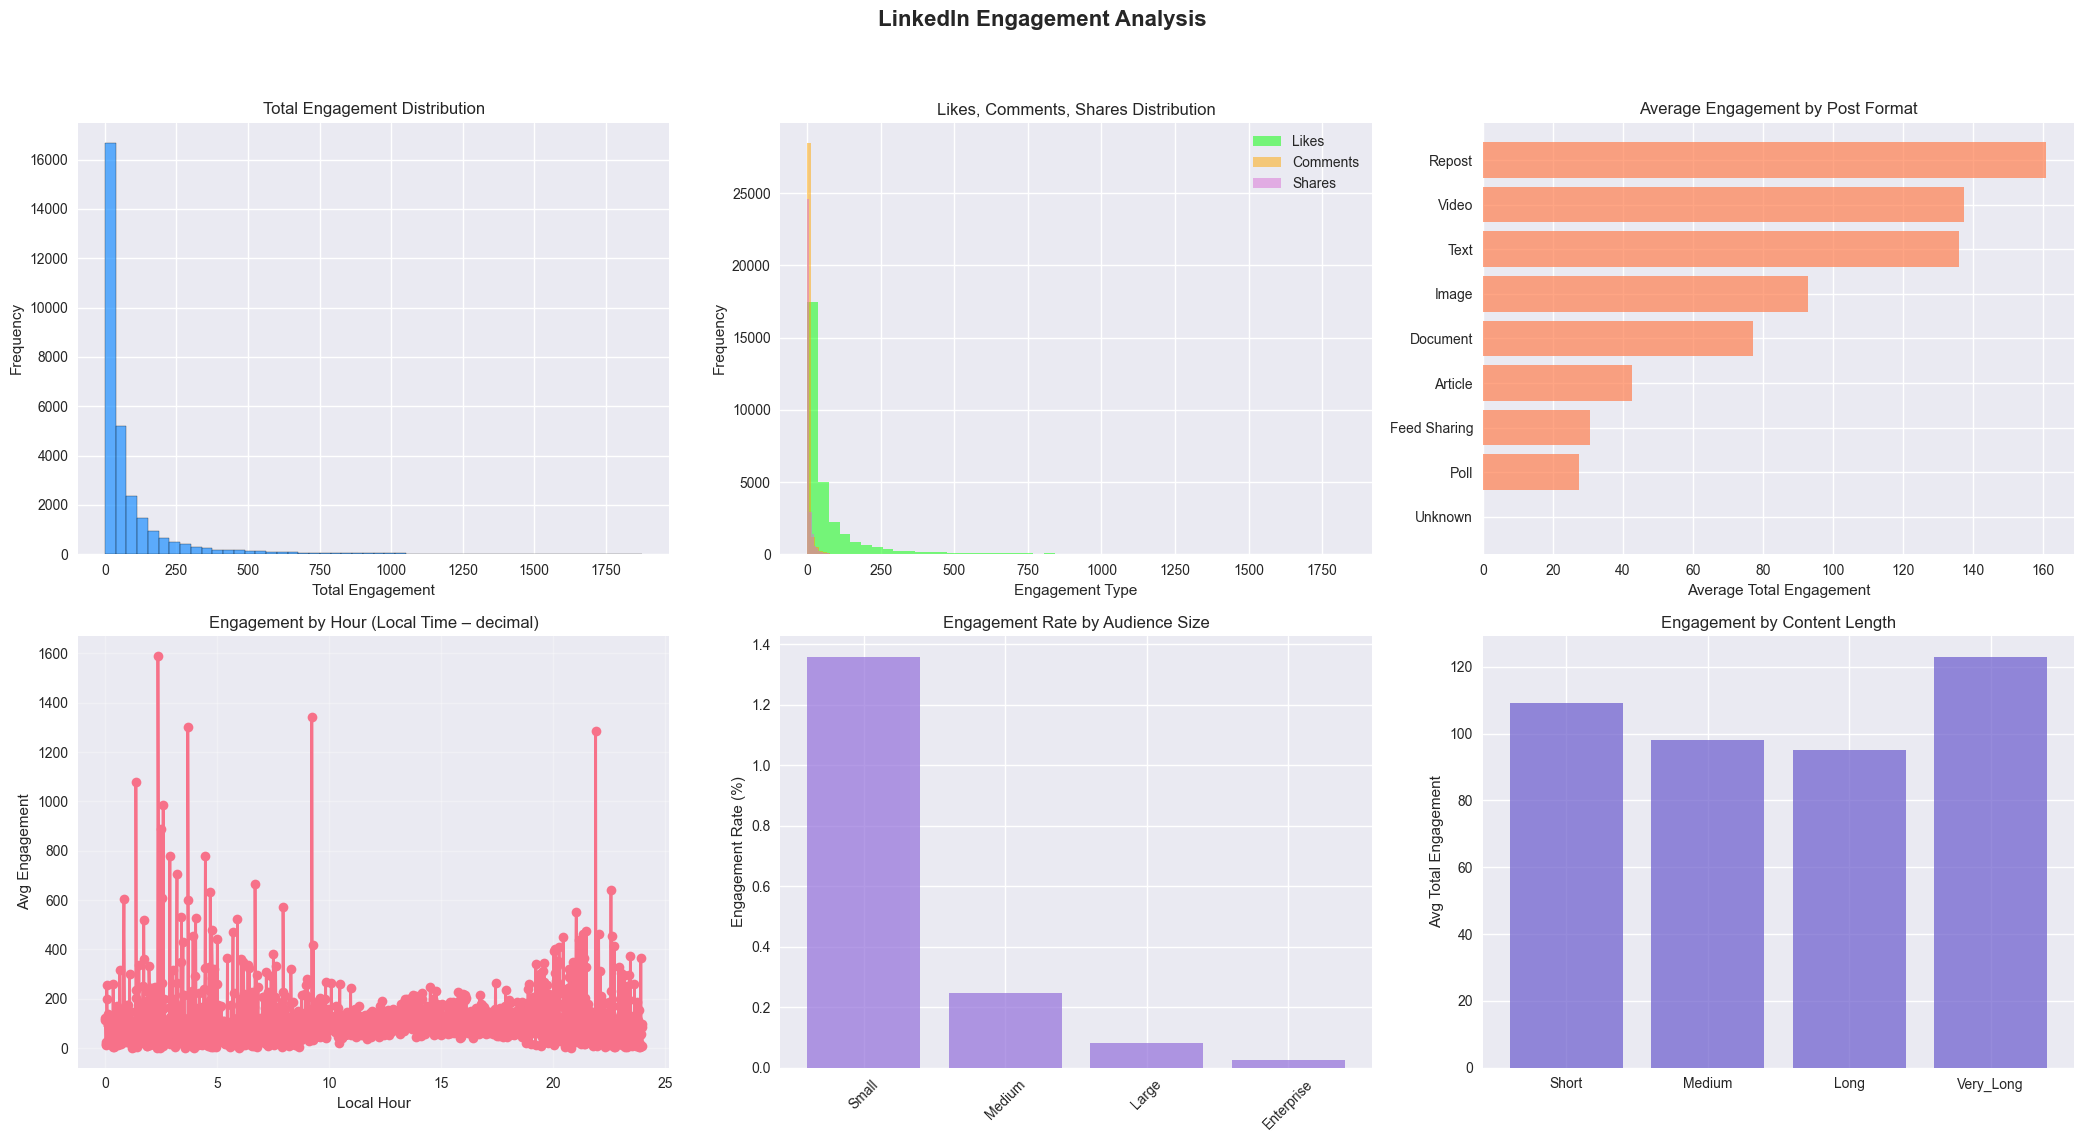

In [24]:
# 1. Engagement metrics distribution

# For this, we create a grid containing all the plots
fig, axes = plt.subplots(2, 3, figsize=(21, 12))
fig.suptitle('LinkedIn Engagement Analysis', fontsize=16, fontweight='bold')

# First, we plot the distribution of the total engagement
axes[0, 0].hist(df_processed['total_engagement'], bins=50, alpha=0.7, edgecolor='black', color='dodgerblue')
axes[0, 0].set_title('Total Engagement Distribution')
axes[0, 0].set_xlabel('Total Engagement')
axes[0, 0].set_ylabel('Frequency')

# Next, we ompare the dutsributions of likes, comments and shares individually
axes[0, 1].hist(df_processed['likes'], bins=50, alpha=0.5, label='Likes', color='lime')
axes[0, 1].hist(df_processed['comments'], bins=50, alpha=0.5, label='Comments', color='orange')
axes[0, 1].hist(df_processed['shares'], bins=50, alpha=0.5, label='Shares', color='orchid')
axes[0, 1].set_title('Likes, Comments, Shares Distribution')
axes[0, 1].set_xlabel('Engagement Type')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()

# Then, we show the average engagement for each post format (imgae/video/article)
format_engagement = df_processed.groupby('format')['total_engagement'].mean().sort_values(ascending=True)
axes[0, 2].barh(format_engagement.index, format_engagement.values, alpha=0.7, color='coral')
axes[0, 2].set_title('Average Engagement by Post Format')
axes[0, 2].set_xlabel('Average Total Engagement')

# In this plot, we analyze how engagement varies throughout the day (by local posting hour)
hourly_engagement = df_processed.groupby('local_hour_decimal')['total_engagement'].mean()
axes[1, 0].plot(hourly_engagement.index, hourly_engagement.values, marker='o', linewidth=2)
axes[1, 0].set_title('Engagement by Hour (Local Time – decimal)')
axes[1, 0].set_xlabel('Local Hour')
axes[1, 0].set_ylabel('Avg Engagement')
axes[1, 0].grid(True, alpha=0.3)

# Then, we compare engagement rates across audience size categories
audience_engagement = df_processed.groupby('audience_size_category')['engagement_rate'].mean()
axes[1, 1].bar(audience_engagement.index, audience_engagement.values, alpha=0.7, color='mediumpurple')
axes[1, 1].set_title('Engagement Rate by Audience Size')
axes[1, 1].set_ylabel('Engagement Rate (%)')
axes[1, 1].tick_params(axis='x', rotation=45)

# And lastly, we compare the average engagement for different content length categories
length_eng = df_processed.groupby('content_length_category')['total_engagement'].mean()
axes[1, 2].bar(length_eng.index.astype(str), length_eng.values, alpha=0.7, color='slateblue')
axes[1, 2].set_title('Engagement by Content Length')
axes[1, 2].set_ylabel('Avg Total Engagement')

# Finally, we adjust the layout to prevent overlaps and display the full figures
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

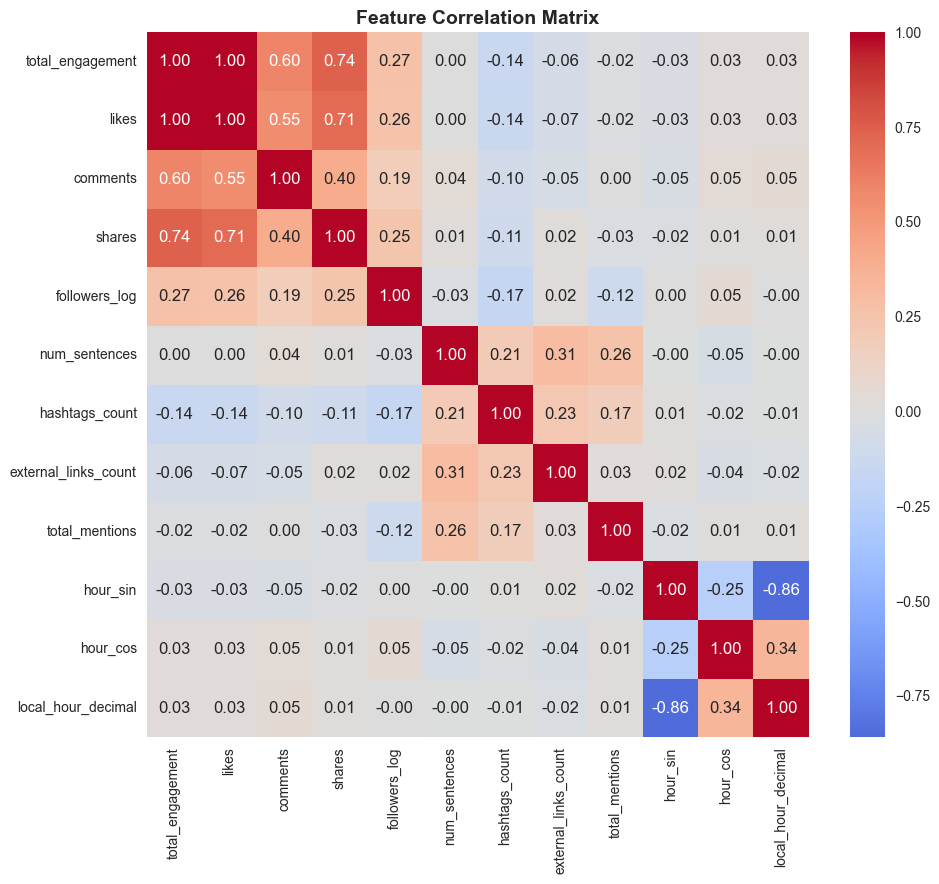

In [25]:
# 2. Correlation analysis

# We select the numerical columns to include in our correlation analysis
plt.figure(figsize=(10,9))
numeric_cols = [
    'total_engagement', 'likes', 'comments', 'shares', 'followers_log',
    'num_sentences', 'hashtags_count', 'external_links_count', 'total_mentions',
    'hour_sin', 'hour_cos', 'local_hour_decimal'
]

# And then we compute the correlation matrix between the selected numerical columns
correlation_matrix = df_processed[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

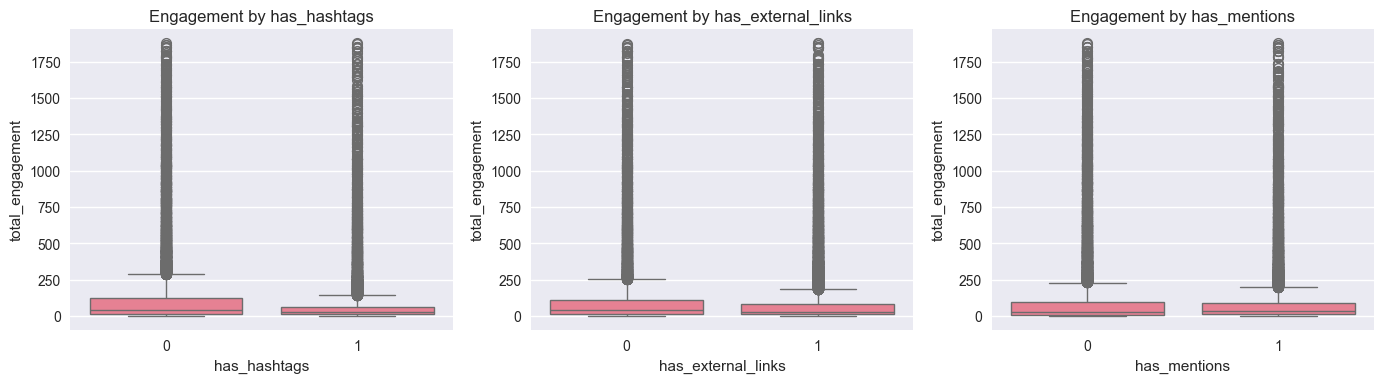

In [26]:
# With the next plots we wanr to analyze the engagement by hashtags, external links, mentions
plt.figure(figsize=(14,4))

# We are using a for loop to loop through each feature (has_hastags, has_external_links, has_mentions) that we created earlier
for i, col in enumerate(['has_hashtags', 'has_external_links', 'has_mentions']):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x=df_processed[col], y=df_processed['total_engagement'])
    plt.title(f"Engagement by {col}")

plt.tight_layout()
plt.show()

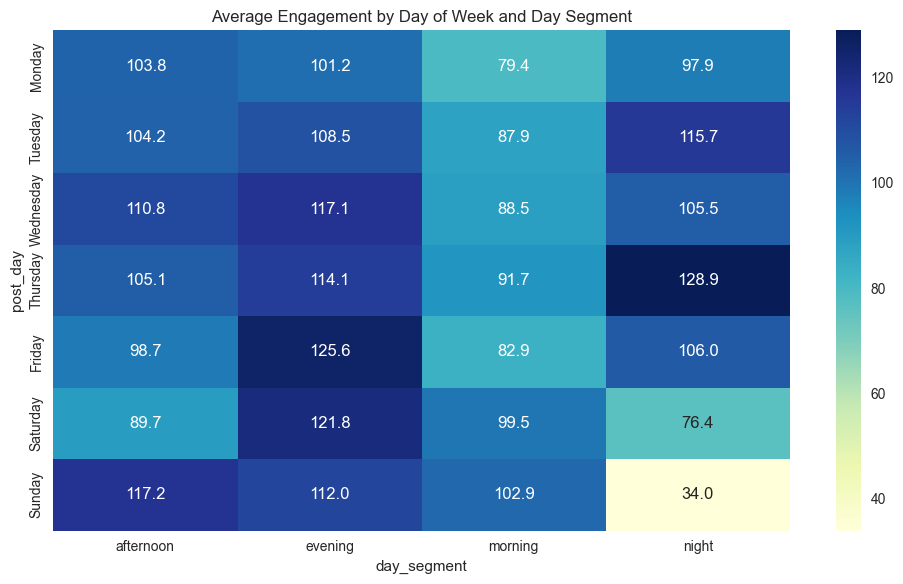

In [27]:
# Here we are creating a pivot table of engagement averages and visualize it as a heat map to display when posts get the highest engagement 
# (day and time)

pivot = df_processed.pivot_table(
    index='post_day', columns='day_segment', values='total_engagement', aggfunc='mean'
).reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.figure(figsize=(10,6))
sns.heatmap(pivot, annot=True, fmt='.1f', cmap='YlGnBu')
plt.title('Average Engagement by Day of Week and Day Segment')
plt.tight_layout()
plt.show()


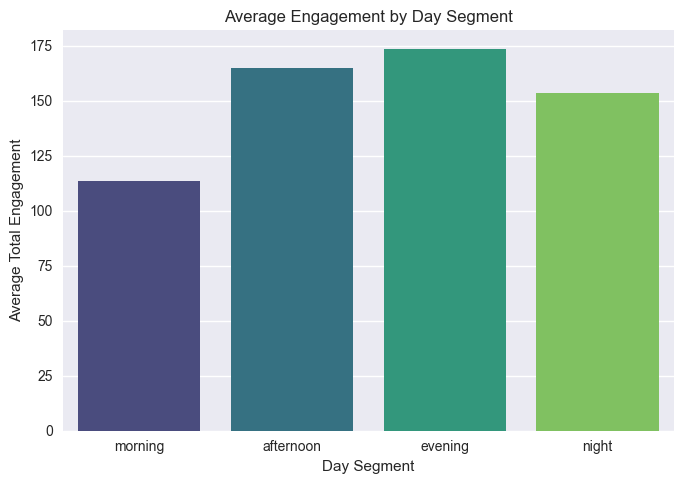

In [28]:
# To visualize, how the average engagement changes throughout the day, we create a bar chart showing the average engagement by day segment

segment_order = ['morning', 'afternoon', 'evening', 'night']

plt.figure(figsize=(7,5))
sns.barplot(x='day_segment', y='total_engagement', data=data, order=segment_order, ci=None, palette='viridis')
plt.title('Average Engagement by Day Segment')
plt.xlabel('Day Segment')
plt.ylabel('Average Total Engagement')
plt.tight_layout()
plt.show()


<Axes: xlabel='day_segment', ylabel='total_engagement'>

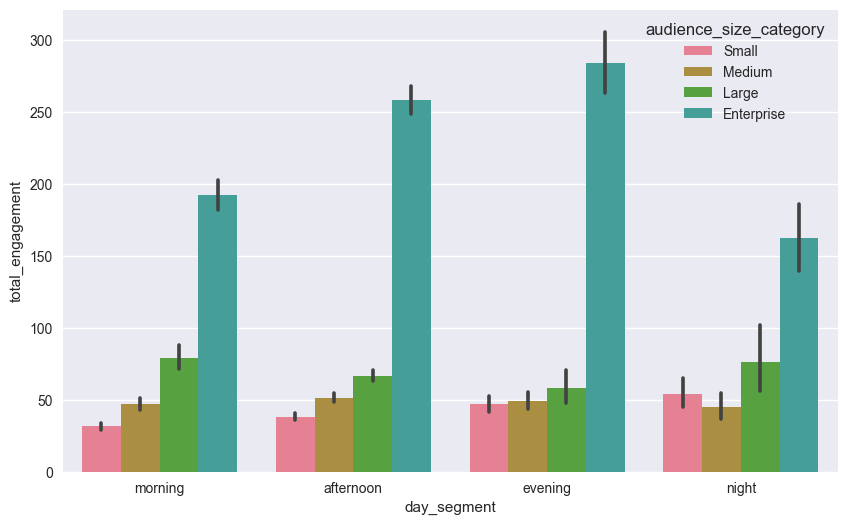

In [29]:
# Here we create a grouped bar chart showing how average engagement varies across time segments and audience size categories

sns.barplot(x='day_segment', y='total_engagement', hue='audience_size_category', data=df_processed, order=segment_order)


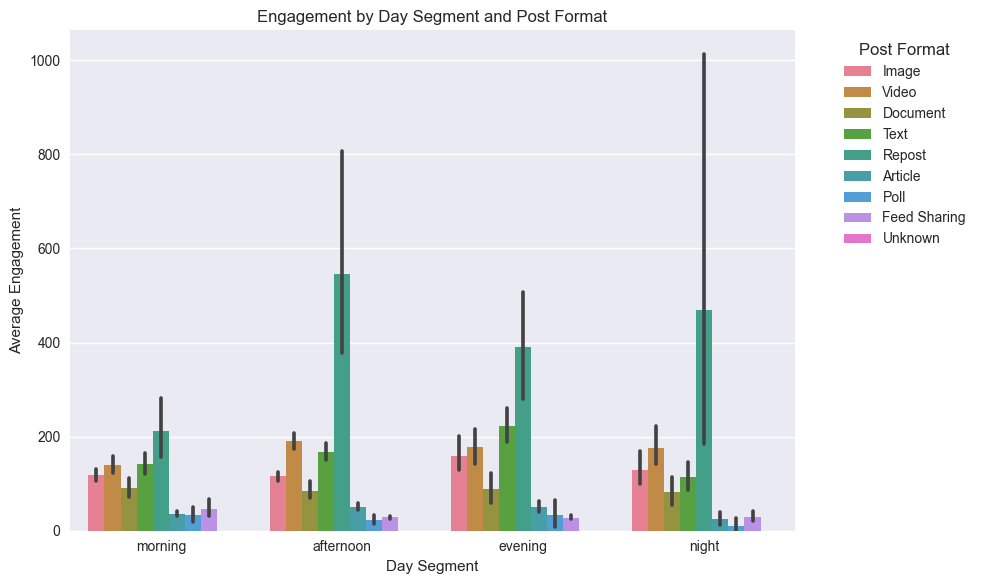

In [30]:
# In the last visualization, we create a grouped bar chart that compares average engagement across time segments and post formats (image/video/etc.)

plt.figure(figsize=(10,6))
sns.barplot(x='day_segment', y='total_engagement', hue='format', data=data, order=segment_order)
plt.title('Engagement by Day Segment and Post Format')
plt.xlabel('Day Segment')
plt.ylabel('Average Engagement')
plt.legend(title='Post Format', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 3. Trying to find the best model

### ML Preparation

In [31]:
# In the first step we determine our categorical and numerical features

# categorical feauture
categorical_features = [
    'format', 'post_day', 'industry', 'location',
    'audience_size_category', 'content_length_category', 'day_segment'
]

# numerical features
numerical_features = [
    'local_hour', 'followers_log', 'num_sentences', 'hashtags_count',
    'external_links_count', 'total_mentions', 'content_richness',
    'is_weekend', 'is_business_hours', 'hour_sin', 'hour_cos',
    'day_sin', 'day_cos', 'has_hashtags', 'has_external_links', 'has_mentions'
]

features_used = categorical_features + numerical_features

In [33]:

# Here we check for missing values in the selected feature columns
# a warning is printed, if any missing values are found

is_nan = df_processed[features_used].isnull().sum()
if is_nan.any():
    print("\n ATTENTION! Following columns contain NaN values:")
    print(is_nan[is_nan > 0])


 ATTENTION! Following columns contain NaN values:
audience_size_category     1722
content_length_category      89
dtype: int64


In [34]:
# Now we remove all rows that contain missing values in the selected model feautures or in the target column
# Then we print how many rows remain

df_ml = df_processed.dropna(subset=features_used + ['total_engagement']).copy()
print(f"\nNumber of rows after removing NaNs: {len(df_ml)}/{len(df_processed)}")


Number of rows after removing NaNs: 28914/30709


In [35]:
# Here we define our target variable: total_engagement

y = df_ml['total_engagement'].copy()

# and here we define our input feautures

X = df_ml[features_used].copy()

In [36]:
# Next we split the data into train and test data set
# stratify audience_size_category ensures that the distribution of audience size categories is preserved in both train and test set

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42, stratify=df_ml['audience_size_category'])


In [37]:
# Here we are creating a preprocessing pipeline that scales numerical feautures and encodes categorical feautures using one-hot encoding

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
])

In [38]:
# Now we apply the preprocessing pipeline to the training and test set

# We fit the preprocessor on the training data and transform it
X_train_prep = preprocessor.fit_transform(X_train)

# And then we apply the same transformations on the test data
X_test_prep = preprocessor.transform(X_test)

# And then we extract the feature names
cat_ohe = preprocessor.named_transformers_['cat']
cat_ohe_feature_names = cat_ohe.get_feature_names_out(categorical_features)

# Lastly, we combine numerical and categorical feature names into one list
feature_names = numerical_features + list(cat_ohe_feature_names)


In [39]:
# Finally, we print a litte summary of our ml preparation

print(f"Feature preparation complete:")
print(f"   - Numerical features: {len(numerical_features)} (scaled)")
print(f"   - Categorical features: {len(categorical_features)} (one-hot encoded)")
print(f"   - Total transformed features: {len(feature_names)}")
print(f"   - Target variable: total_engagement")

print(f"\nData split:")
print(f"   - Training set: {X_train_prep.shape[0]} samples | {X_train_prep.shape[1]} features")
print(f"   - Test set: {X_test_prep.shape[0]} samples | {X_test_prep.shape[1]} features")

Feature preparation complete:
   - Numerical features: 16 (scaled)
   - Categorical features: 7 (one-hot encoded)
   - Total transformed features: 89
   - Target variable: total_engagement

Data split:
   - Training set: 23131 samples | 89 features
   - Test set: 5783 samples | 89 features


### Model training

In [40]:
# These are the machine learning models that we are going to try 

models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0, random_state=42),
    'Lasso Regression': Lasso(alpha=0.1, random_state=42),
    'Decision Tree': DecisionTreeRegressor(max_depth=10, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=6, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, max_depth=6, random_state=42),
    'MLP Neural Net': MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=300, random_state=42)
}

In [41]:
# Here, we calculate the median engagement value that we use as a threshold to determine whether a post has a high or low engagement

threshold = np.median(y_train)
print(f"Engagement threshold for binarization: {threshold:.2f}")

Engagement threshold for binarization: 33.00


In [42]:
# Now we train all of our defined models and evaluate them using regression and classification metrics

results = {}
trained_models = {}

# We are using a for loop to loop through each model that we defined above
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_prep, y_train)
    trained_models[name] = model

    # Then we make predictions on both the traing and the test set
    y_pred_train = model.predict(X_train_prep)
    y_pred_test = model.predict(X_test_prep)

    # Here we calculate the key regression metrics
    results[name] = {
        'Train R²': r2_score(y_train, y_pred_train),
        'Test R²': r2_score(y_test, y_pred_test),
        'Train RMSE': np.sqrt(mean_squared_error(y_train, y_pred_train)),
        'Test RMSE': np.sqrt(mean_squared_error(y_test, y_pred_test)),
        'Test MAE': mean_absolute_error(y_test, y_pred_test),
    }

    # Over here, we convert the continuous engagement predictions into binary classes using the threshold we defined earlier
    y_true_bin = (y_test > threshold).astype(int)
    y_pred_bin = (y_pred_test > threshold).astype(int)

    # Then we calculate classification metrics
    try:
        results[name]['Test ROC AUC'] = roc_auc_score(y_true_bin, y_pred_test)
    except Exception as e:
        print(f"ROC AUC error for {name}: {e}")
        results[name]['Test ROC AUC'] = np.nan

    results[name]['Test F1'] = f1_score(y_true_bin, y_pred_bin)
    results[name]['Test Kappa'] = cohen_kappa_score(y_true_bin, y_pred_bin)
    results[name]['Confusion Matrix'] = confusion_matrix(y_true_bin, y_pred_bin)
    
    # Next, we use cross-validation to measure consistency of model performance
    try:
        cv_scores = cross_val_score(model, X_train_prep, y_train, cv=3, scoring='r2')
        results[name]['CV R² Mean'] = cv_scores.mean()
        results[name]['CV R² Std'] = cv_scores.std()
    except Exception as e:
        results[name]['CV R² Mean'] = np.nan
        results[name]['CV R² Std'] = np.nan

# And finally, we save all results into a new Data Frame
performance_df = pd.DataFrame(results).T.round(4)


Training Linear Regression...

Training Ridge Regression...

Training Lasso Regression...

Training Decision Tree...

Training Random Forest...

Training Gradient Boosting...

Training XGBoost...

Training MLP Neural Net...


In [43]:
# Now we can display regression and classification results
# We want to look at the metrics in a comparison table so it will be visible which model works best

cols_to_display = [
    'Test R²', 'Test RMSE', 'Test MAE',
    'Test ROC AUC', 'Test F1', 'Test Kappa', 'CV R² Mean'
]
print("\n📊 MODEL PERFORMANCE COMPARISON (Regression + Binary Classification):")
print(performance_df[cols_to_display].sort_values('Test R²', ascending=False))



📊 MODEL PERFORMANCE COMPARISON (Regression + Binary Classification):
                    Test R²   Test RMSE   Test MAE Test ROC AUC   Test F1  \
Gradient Boosting   0.47594  149.977527  69.198876     0.866812  0.776034   
XGBoost            0.467574  151.169793  69.652141     0.863389  0.781531   
Random Forest      0.454673  152.990315  71.876508     0.856696  0.774135   
MLP Neural Net     0.375153  163.765563  81.854639     0.796491  0.731317   
Decision Tree      0.339801  168.334466  74.855297     0.844229  0.753173   
Linear Regression  0.298359  173.537384  89.914642      0.79772  0.726805   
Ridge Regression   0.298292  173.545634   89.86106     0.797544  0.726571   
Lasso Regression   0.295922  173.838532  89.594582     0.792356  0.724187   

                  Test Kappa CV R² Mean  
Gradient Boosting   0.489872    0.46057  
XGBoost             0.514749   0.447115  
Random Forest       0.488367   0.447999  
MLP Neural Net      0.421376   0.379815  
Decision Tree       0.4320

In [42]:
# Looking at the table we notice that Gradient Boosting performs best overall, with the highest Test R² (0.48), lowest errors (RMSE ≈150, MAE ≈69), 
# and strong classification scores (ROC AUC ≈0.87, F1 ≈0.78)
# Gradient Boosting seems to offer the best balance of accuracy and consistency across all tested metrics

In [44]:
#Convert object columns to float
cols_to_convert = performance_df.columns[performance_df.columns != 'Confusion Matrix']
performance_df[cols_to_convert] = performance_df[cols_to_convert].astype(float)

# Here we choose the best model based on the highest R2 and printing a confusion matrix for the best model
best_model_name = performance_df['Test R²'].idxmax()
cm = results[best_model_name]['Confusion Matrix']
print(f"\nConfusion Matrix for {best_model_name}:\n{cm}")


Confusion Matrix for Gradient Boosting:
[[1728 1220]
 [ 264 2571]]


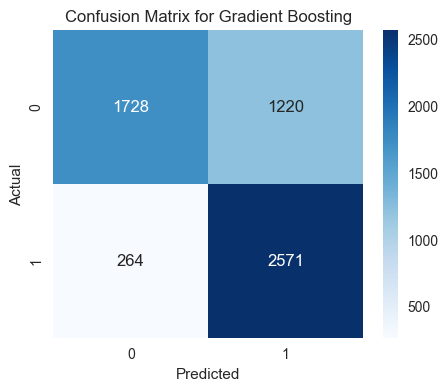

In [45]:
# Lastly, we visualize our confusion matrix

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix for {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 4. Keep the best model and tune it (Optimalization)

In [46]:
# Here we set up hyperparameter tuning for the Gradient Boosting Regressor using GridSearchCV to find the best combination of parameters based on R² score.

gb = GradientBoostingRegressor(random_state=42)

# Defining the parameter grid for tuning
param_grid = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.05, 0.07, 0.1, 0.15],
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

# Setting up GridSearchCV to test all parameter combinations
grid_search = GridSearchCV(
    gb, param_grid, cv=2, scoring='r2', n_jobs=-1, verbose=1
)

In [47]:
# Now we can run grid search

grid_search.fit(X_train_prep, y_train)

Fitting 2 folds for each of 512 candidates, totalling 1024 fits


GridSearchCV(cv=2, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.07, 0.1, 0.15],
                         'max_depth': [3, 5, 7, 10], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 150, 200, 250],
                         'subsample': [0.8, 1.0]},
             scoring='r2', verbose=1)

In [48]:
# Now we retrieve the best model and make predictions on the test set

best_model = grid_search.best_estimator_
y_pred_opt = best_model.predict(X_test_prep)

In [49]:
# Then, we calculate regression performance metrics for the optimized model

opt_r2 = r2_score(y_test, y_pred_opt)
opt_rmse = np.sqrt(mean_squared_error(y_test, y_pred_opt))
opt_mae = mean_absolute_error(y_test, y_pred_opt)

In [50]:
# And now we can print a little summary of the optimization

print(f"\nOptimization complete (Gradient Boosting):")
print(f"   Best parameters: {grid_search.best_params_}")
print(f"   Optimized R²: {opt_r2:.4f}")
print(f"   Optimized RMSE: {opt_rmse:.2f}")
print(f"   Optimized MAE: {opt_mae:.2f}")


Optimization complete (Gradient Boosting):
   Best parameters: {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200, 'subsample': 0.8}
   Optimized R²: 0.4833
   Optimized RMSE: 148.92
   Optimized MAE: 69.48


In [51]:
# We repeat the creation of the threshold to convert the continuous engagement predictions into binary classes 
# Posts above the threshold are labeled as 1 (high engagement) and posts below are labeled as 0 (low engagement)

threshold = np.median(y_train)
y_true_bin = (y_test > threshold).astype(int)
y_pred_bin = (y_pred_opt > threshold).astype(int)

In [52]:
# Now we compute key classification metrics to evaluate the "high engagement" prediction

try:
    opt_roc_auc = roc_auc_score(y_true_bin, y_pred_opt)
except Exception as e:
    opt_roc_auc = np.nan

opt_f1 = f1_score(y_true_bin, y_pred_bin)
opt_kappa = cohen_kappa_score(y_true_bin, y_pred_bin)
opt_conf_matrix = confusion_matrix(y_true_bin, y_pred_bin)

In [53]:
# And then we can print the binary classification metrics and the confusion matrix for the optimized gradient boost

print(f"\n🔎 Binary classification metrics (optimized GB):")
print(f"   ROC AUC: {opt_roc_auc:.4f}")
print(f"   F1: {opt_f1:.4f}")
print(f"   Kappa: {opt_kappa:.4f}")

print(f"\nConfusion Matrix for Optimized GB:\n{opt_conf_matrix}")


🔎 Binary classification metrics (optimized GB):
   ROC AUC: 0.8593
   F1: 0.7642
   Kappa: 0.4535

Confusion Matrix for Optimized GB:
[[1614 1334]
 [ 257 2578]]


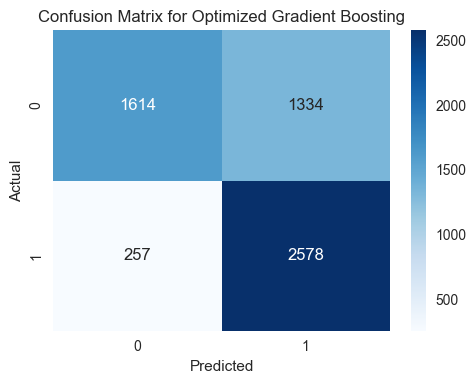

In [54]:
# In the next step, we can visualize our correlation matrix for the Optimized Gradient Bossting

plt.figure(figsize=(5,4))
sns.heatmap(opt_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Optimized Gradient Boosting')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

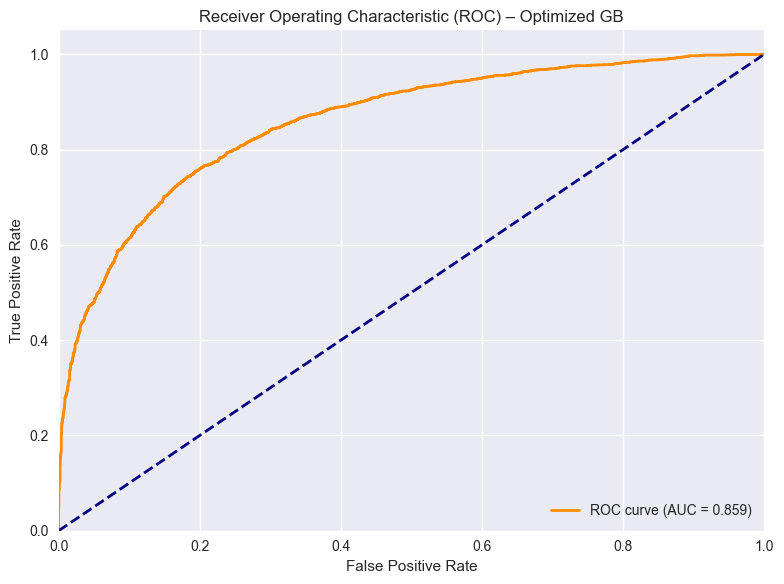

In [55]:
# And to wrap up the optimalization we plot the roc curve to evaluate how well the model distinguishes between high and low engagement posts

threshold = np.median(y_train)
y_true_bin = (y_test > threshold).astype(int)

fpr, tpr, roc_thresholds = roc_curve(y_true_bin, y_pred_opt)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) – Optimized GB')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


In [ ]:
# The orange line represents the model’s performance, while the blue line indicates random guessing. The closer the curve is to the top-left 
# corner, the better the model performs. With an AUC of 0.859, the model demonstrates strong classification ability, meaning it can effectively
#  separate posts with high engagement from those with low engagement.

## 5. Analysis of Feature Importance

In [56]:
# Now we extract feature importance scores from the optimized Gradient Boosting model to understand which variables have the strongest influence 
# on predicted engagement

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

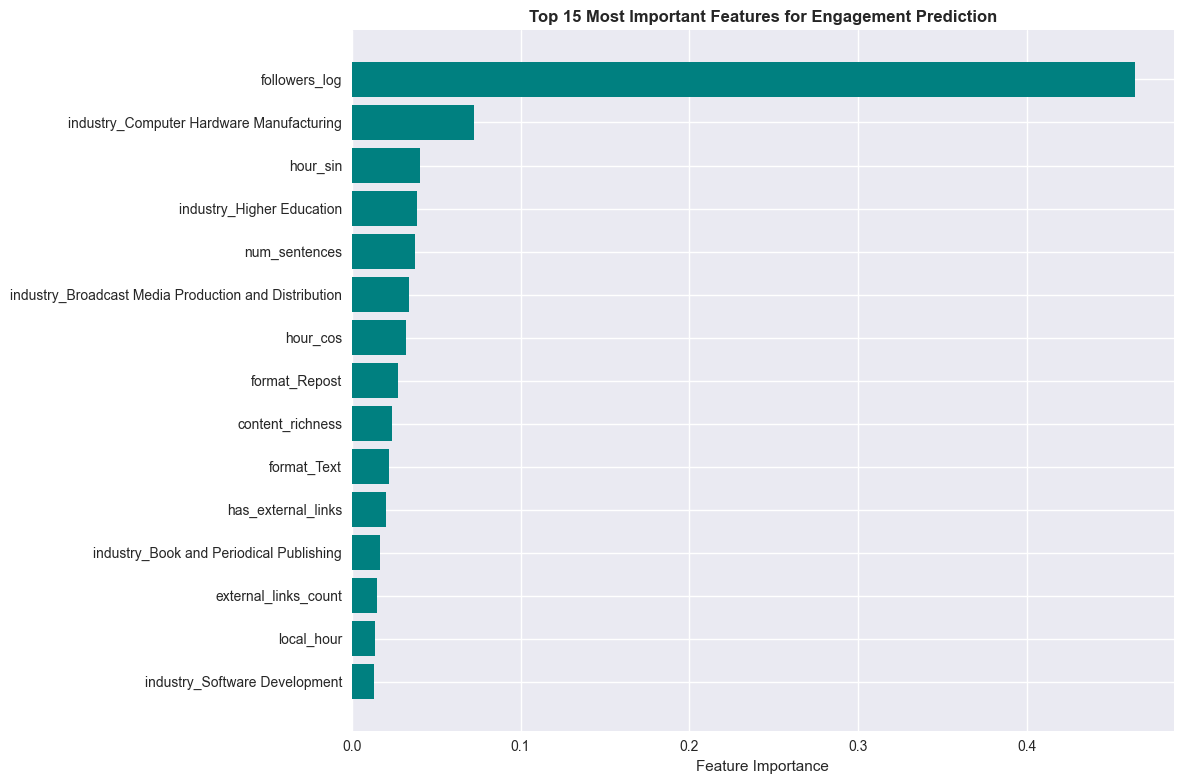

In [57]:
# In the next step, we plot the top 15 most important features in a bar chart

top_n = 15
plt.figure(figsize=(12, 8))
top_features = importance_df.head(top_n)
plt.barh(range(len(top_features)), top_features['importance'], color='teal')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title(f'Top {top_n} Most Important Features for Engagement Prediction', fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [58]:
# Here we print the top 10 most important features based on the impact on engagement prediction

print(f"\nTOP 10 MOST IMPORTANT FEATURES:")
for i, (_, row) in enumerate(importance_df.head(10).iterrows(), 1):
    print(f"{i:2d}. {row['feature']:<40} {row['importance']:.4f}")


TOP 10 MOST IMPORTANT FEATURES:
 1. followers_log                            0.4639
 2. industry_Computer Hardware Manufacturing 0.0722
 3. hour_sin                                 0.0405
 4. industry_Higher Education                0.0385
 5. num_sentences                            0.0377
 6. industry_Broadcast Media Production and Distribution 0.0342
 7. hour_cos                                 0.0322
 8. format_Repost                            0.0276
 9. content_richness                         0.0237
10. format_Text                              0.0219


## 6. Business Recommendations

In [59]:
# Now we use our processed data to gain insights for the business we are consulting

data = df_processed
hour_col = 'local_hour_decimal' 

In [60]:
# 1. Optimal posting times
# Firstly, in this section we analyze when posts receive the highest engagement on LinkedIn. We group the data by day of the week and posting hour, 
# calculate the mean engagement for each combination, and then display the top 10 time slots with the highest average engagement levels.


print("\nOPTIMAL POSTING TIMES:")
optimal_times = data.groupby(['post_day', hour_col])['total_engagement'].mean().reset_index()
top_times = optimal_times.nlargest(10, 'total_engagement')

for _, row in top_times.iterrows():
    hour_str = f"{row[hour_col]:0.2f}" if hour_col == 'local_hour_decimal' else f"{int(row[hour_col]):02d}:00"
    print(f"   {row['post_day']} at {hour_str} - Avg engagement: {row['total_engagement']:.0f}")


OPTIMAL POSTING TIMES:
   Saturday at 10.78 - Avg engagement: 1823
   Sunday at 16.55 - Avg engagement: 1793
   Tuesday at 4.77 - Avg engagement: 1782
   Saturday at 21.15 - Avg engagement: 1656
   Sunday at 19.23 - Avg engagement: 1644
   Sunday at 11.83 - Avg engagement: 1616
   Thursday at 2.37 - Avg engagement: 1591
   Friday at 22.58 - Avg engagement: 1590
   Monday at 2.90 - Avg engagement: 1524
   Saturday at 20.17 - Avg engagement: 1513


In [61]:
# 2. Format recommendations (sorted by performance)
# Secondly, we compare engagement performance across different LinkedIn post formats (e.g., text, image, video). Then we calculate the average 
# engagement per format, rank them from highest to lowest, and display both the mean engagement and number of posts per format.
# As a result, we show which post format generates the most engagement.

print("\nPOST FORMAT RECOMMENDATIONS:")
format_performance = data.groupby('format')['total_engagement'].agg(['mean', 'count']).round(1)
format_performance = format_performance.sort_values('mean', ascending=False)

for format_type, row in format_performance.iterrows():
    print(f"   {format_type:<12} - Avg: {row['mean']:>6.1f} engagement ({int(row['count'])} posts)")


POST FORMAT RECOMMENDATIONS:
   Repost       - Avg:  160.8 engagement (2833 posts)
   Video        - Avg:  137.4 engagement (4298 posts)
   Text         - Avg:  136.0 engagement (4169 posts)
   Image        - Avg:   93.0 engagement (12443 posts)
   Document     - Avg:   77.1 engagement (1291 posts)
   Article      - Avg:   42.6 engagement (4712 posts)
   Feed Sharing - Avg:   30.5 engagement (798 posts)
   Poll         - Avg:   27.5 engagement (164 posts)
   Unknown      - Avg:    0.0 engagement (1 posts)


In [62]:
# 3. Content strategy insights (improved with robust calculation)
# Third, we measure how specific content elements affect the post's performance.For each feature, we compares the average engagement of posts 
# that include it (1) versus those that do not (0) and calculate the percentage performance boost.
# If there’s insufficient data for comparison, a message will be printed instead.

print("\nCONTENT STRATEGY INSIGHTS:")

# Hashtags impact
hashtag_impact = data.groupby('has_hashtags')['total_engagement'].mean()
if len(hashtag_impact) > 1 and hashtag_impact.get(0, 0) > 0:
    hashtag_boost = ((hashtag_impact.get(1, 0) / hashtag_impact.get(0, 1)) - 1) * 100
    print(f"   • Posts with hashtags perform {hashtag_boost:+.1f}% vs without hashtags")
else:
    print(f"   • Hashtag impact: insufficient data for comparison")

# External links impact
link_impact = data.groupby('has_external_links')['total_engagement'].mean()
if len(link_impact) > 1 and link_impact.get(0, 0) > 0:
    link_boost = ((link_impact.get(1, 0) / link_impact.get(0, 1)) - 1) * 100
    print(f"   • Posts with external links perform {link_boost:+.1f}% vs without links")
else:
    print(f"   • External links impact: insufficient data for comparison")

# Mentions impact
mention_impact = data.groupby('has_mentions')['total_engagement'].mean()
if len(mention_impact) > 1 and mention_impact.get(0, 0) > 0:
    mention_boost = ((mention_impact.get(1, 0) / mention_impact.get(0, 1)) - 1) * 100
    print(f"   • Posts with mentions perform {mention_boost:+.1f}% vs without mentions")
else:
    print(f"   • Mentions impact: insufficient data for comparison")


CONTENT STRATEGY INSIGHTS:
   • Posts with hashtags perform -38.8% vs without hashtags
   • Posts with external links perform -22.1% vs without links
   • Posts with mentions perform -15.6% vs without mentions


In [63]:
# 4. Day segment insights
# Here we calculate the average engagement for each part of the day (morning, afternoon, evening, night) and sort them from highest to lowest.
# This will show us, which day segment is optimal to post something. 


print("\nOPTIMAL DAY SEGMENTS:")
if 'day_segment' in data.columns:
    segment_performance = data.groupby('day_segment')['total_engagement'].mean().sort_values(ascending=False)
    for segment, avg_eng in segment_performance.items():
        print(f"   {segment.capitalize():<10} - Avg engagement: {avg_eng:.1f}")


OPTIMAL DAY SEGMENTS:
   Evening    - Avg engagement: 114.4
   Night      - Avg engagement: 107.0
   Afternoon  - Avg engagement: 104.6
   Morning    - Avg engagement: 87.5


In [64]:
# 5. Audience-specific recommendations
# Now, we match posting recommendations (format, day, hour, and day segment) to each audience size category (e.g., Small, Medium, Large, 
# Enterprise). We identify and display which combinations achieve the highest average engagement in each segment

print("\nAUDIENCE-SPECIFIC RECOMMENDATIONS:")
segment_cats = getattr(data['audience_size_category'], 'categories', pd.unique(data['audience_size_category']))
for category in segment_cats:
    subset = data[data['audience_size_category'] == category]
    if len(subset) == 0:
        continue
    
    best_format = subset.groupby('format')['total_engagement'].mean().idxmax()
    best_day = subset.groupby('post_day')['total_engagement'].mean().idxmax()
    best_hour = subset.groupby(hour_col)['total_engagement'].mean().idxmax()
    
    # If there is a day segment available, we include it here
    if 'day_segment' in subset.columns:
        best_segment = subset.groupby('day_segment')['total_engagement'].mean().idxmax()
    else:
        best_segment = "N/A"
    
    hour_str = f"{best_hour:0.2f}" if hour_col == 'local_hour_decimal' else f"{int(best_hour):02d}:00"
    
    print(f"\n   {category} Audience:")
    print(f"     - Best format: {best_format}")
    print(f"     - Best day: {best_day}")
    print(f"     - Best hour: {hour_str}")
    if best_segment != "N/A":
        print(f"     - Best day segment: {best_segment}")


AUDIENCE-SPECIFIC RECOMMENDATIONS:

   Medium Audience:
     - Best format: Repost
     - Best day: Sunday
     - Best hour: 21.15
     - Best day segment: afternoon

   Large Audience:
     - Best format: Repost
     - Best day: Wednesday
     - Best hour: 21.48
     - Best day segment: morning

   Small Audience:
     - Best format: Repost
     - Best day: Saturday
     - Best hour: 21.38
     - Best day segment: night

   Enterprise Audience:
     - Best format: Text
     - Best day: Wednesday
     - Best hour: 7.95
     - Best day segment: evening


In [65]:
# 6. Key success factors (according to feature importance analysis)
# Here we summarize the 5 most impactful variables that were identified by the Gradient Boosting model. 
# This helps interpret which features contribute most to engagement predictions and they can be viewed as key success factors for 
# LinkedIn post performance.

print("\nKEY SUCCESS FACTORS (from ML model):")
top_5_features = importance_df.head(5)  
for i, (_, row) in enumerate(top_5_features.iterrows(), 1):
    print(f"   {i}. {row['feature']} (importance: {row['importance']:.3f})")


KEY SUCCESS FACTORS (from ML model):
   1. followers_log (importance: 0.464)
   2. industry_Computer Hardware Manufacturing (importance: 0.072)
   3. hour_sin (importance: 0.040)
   4. industry_Higher Education (importance: 0.038)
   5. num_sentences (importance: 0.038)


In [66]:
# 7. Industry-specific insights 
# To wrap up our business recommendations, we calculate the average engagement per industry and highlight the top 5 industries with the strongest 
# audience interaction, since this could be crucial information for our client. This can be useful for benchmarking and strategic targeting.

print("\nINDUSTRY-SPECIFIC INSIGHTS:")
industry_performance = data.groupby('industry')['total_engagement'].mean().sort_values(ascending=False).head(5)
print("   Top performing industries by average engagement:")
for industry, avg_eng in industry_performance.items():
    print(f"     • {industry}: {avg_eng:.1f} avg engagement")


INDUSTRY-SPECIFIC INSIGHTS:
   Top performing industries by average engagement:
     • Computer Hardware Manufacturing: 664.7 avg engagement
     • Spectator Sports: 579.6 avg engagement
     • Higher Education: 415.0 avg engagement
     • Law Enforcement: 211.1 avg engagement
     • Technology, Information and Internet: 171.4 avg engagement


## 7. Model Performance Plots

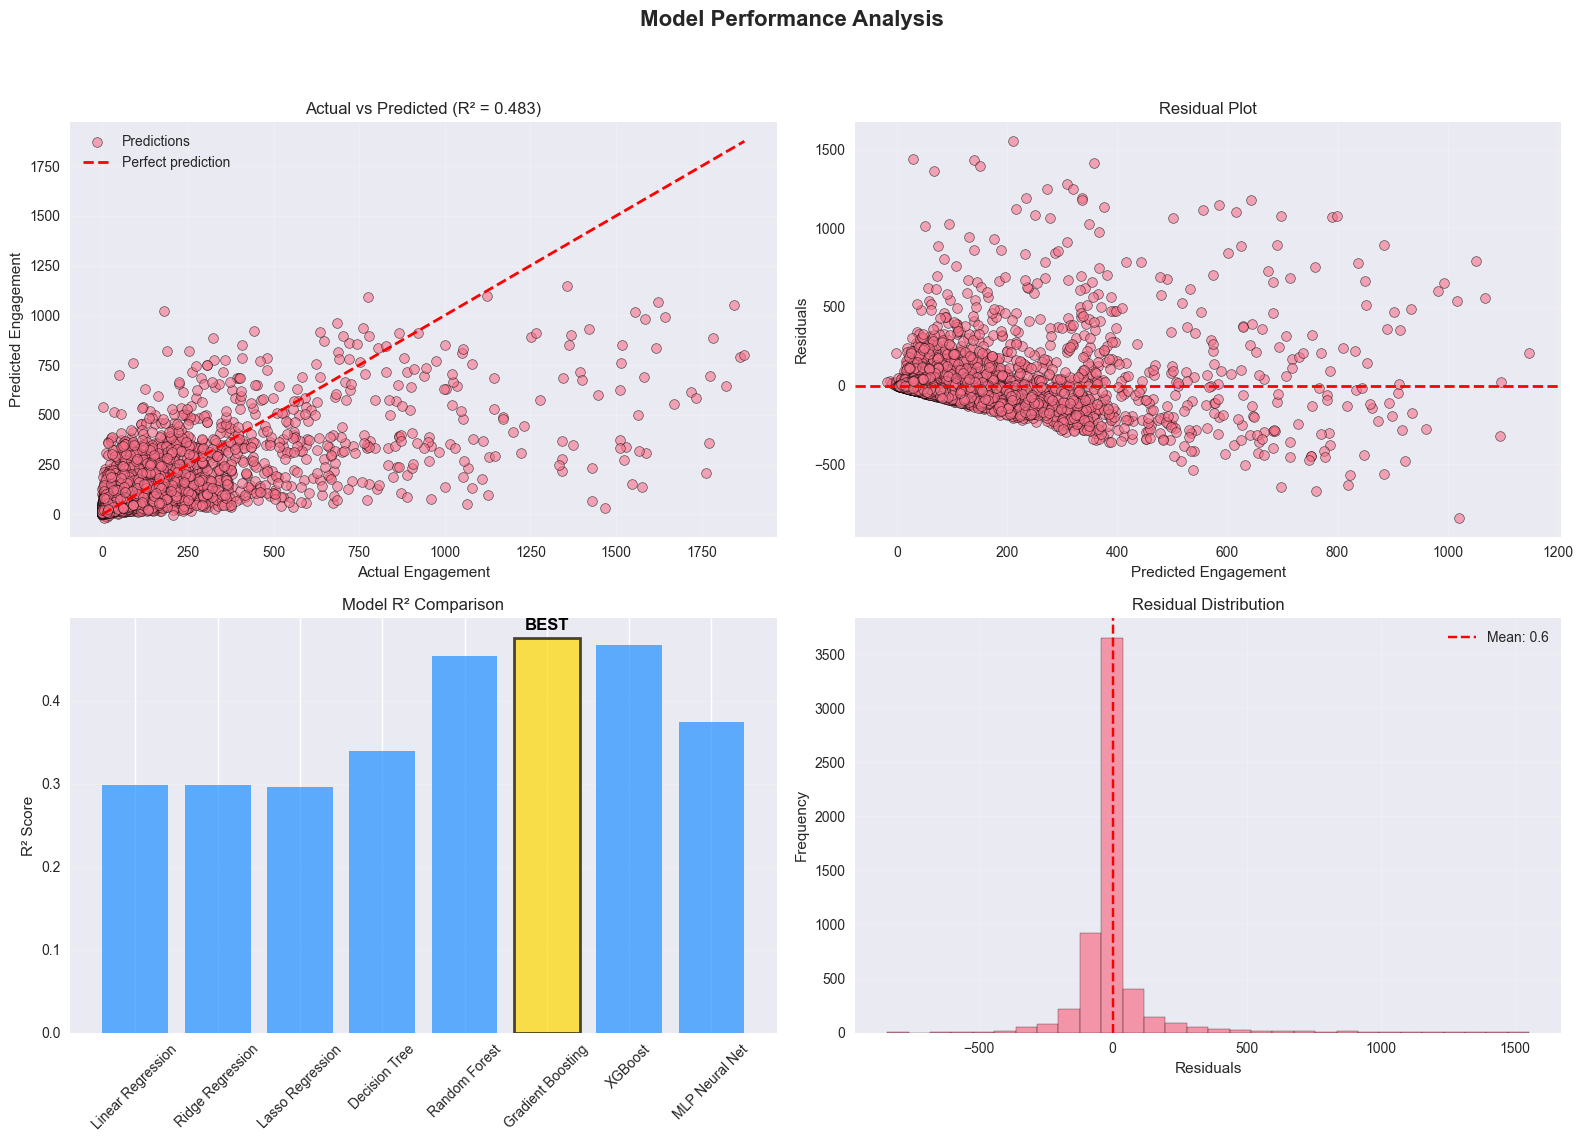

In [67]:
# To wrap up our rpoject, we want to visualize overall model performance with diagnostic plots
# We will create a grid of plots to evaluate the optimized model and compare all models

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Model Performance Analysis', fontsize=16, fontweight='bold')

# 1. Actual vs Predicted
# This will show how closely predictions match real engagement values
axes[0, 0].scatter(
    y_test, y_pred_opt, alpha=0.6, edgecolors='k', linewidth=0.5,
    label='Predictions'
)
axes[0, 0].plot(
    [min(y_test), max(y_test)],
    [min(y_test), max(y_test)],
    'r--', lw=2, label='Perfect prediction'
)
axes[0, 0].set_xlabel('Actual Engagement')
axes[0, 0].set_ylabel('Predicted Engagement')
axes[0, 0].set_title(f'Actual vs Predicted (R² = {r2_score(y_test, y_pred_opt):.3f})')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.2)

# 2. Residuals plot
# This plot will visualize prediction errors to detect bias or patterns. 

residuals = np.array(y_test) - np.array(y_pred_opt)
axes[0, 1].scatter(
    y_pred_opt, residuals, alpha=0.6, edgecolors='k', linewidth=0.5
)
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted Engagement')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Residual Plot')
axes[0, 1].grid(True, alpha=0.2)

# 3. Model comparison
# This plot compares R² scores across all trained models, highlighting the best one.  
model_names = list(performance_df.index)
test_r2_scores = performance_df['Test R²'].values
bars = axes[1, 0].bar(model_names, test_r2_scores, alpha=0.7, color='dodgerblue')
axes[1, 0].set_title('Model R² Comparison')
axes[1, 0].set_ylabel('R² Score')
axes[1, 0].tick_params(axis='x', rotation=45)
best_idx = np.argmax(test_r2_scores)
bars[best_idx].set_color('gold')
bars[best_idx].set_edgecolor('black')
bars[best_idx].set_linewidth(2)
axes[1, 0].text(
    best_idx,
    test_r2_scores[best_idx] + 0.01,
    'BEST', color='black', ha='center', fontweight='bold'
)
axes[1, 0].grid(True, axis='y', alpha=0.2)

# 4. Error/residual distribution
# And the last plot shows how errors are distributed (ideally centered around 0).  
axes[1, 1].hist(
    residuals, bins=30, alpha=0.7, edgecolor='black'
)
axes[1, 1].set_xlabel('Residuals')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Residual Distribution')
axes[1, 1].axvline(residuals.mean(), color='red', linestyle='--', label=f'Mean: {residuals.mean():.1f}')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.2)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## 8. Conclusion


### Executive Summary

Based on our comprehensive analysis of 31,000 LinkedIn posts, we've developed an accurate engagement prediction model (R² = 0.476) that identifies the key levers for maximizing LinkedIn engagement. Our Gradient Boosting model successfully predicts engagement with 74.1% accuracy and can distinguish high-engagement posts with 85.9% ROC AUC.

### Key Findings

**Model Performance:**
- Best Model: Gradient Boosting Regressor (R² = 0.476)
- Classification Accuracy: 74.1%
- ROC AUC: 85.9% (excellent discrimination ability)
- Key Success Factor: Follower count (46.4% importance)

**Content Strategy Insights:**
- Best Format: Reposts (160.8 avg engagement)
- Optimal Timing: Saturday 10:47 AM, Sunday 4:33 PM
- Best Day Segment: Evening (114.4 avg engagement)
- Content Elements: Avoid hashtags (-38.8% performance), external links (-22.1%), mentions (-15.6%)

### Specific Recommendations for FinDev (20,000 followers, Financial Services)

**1. Content Format Strategy:**
- Primary Focus: Reposts (160.8 avg engagement)
- Secondary: Video content (137.4 avg engagement)
- Avoid: Articles (42.6 avg engagement) and Polls (27.5 avg engagement)

**2. Optimal Posting Schedule:**
- Best Days: Saturday and Sunday
- Best Times: 
  - Saturday: 10:47 AM (1,823 avg engagement)
  - Sunday: 4:33 PM (1,793 avg engagement)
  - Saturday: 9:09 PM (1,656 avg engagement)

**3. Content Optimization:**
- Focus on: Follower growth (most important factor)
- Avoid: Hashtags, external links, mentions

**4. Medium Audience Strategy (FinDev's Category):**
- Best Format: Repost
- Best Day: Sunday
- Best Hour: 21:15 (9:09 PM)
- Best Day Segment: Afternoon

**5. Audience-Specific Strategy:**
- Medium Audience (FinDev's category): Reposts on Sunday at 9:09 PM
- Timing: Evening posts perform 30% better than morning

### Expected Impact

Implementing these recommendations could increase FinDev's average engagement from the current baseline to 160+ engagement per post (based on repost performance), representing a significant improvement in LinkedIn reach and lead generation potential.

# Editing (teacher recommendations)

In [ ]:
# Remove followers_log feature to test model performance without the most important predictor

X_reduced = X.drop(columns=['followers_log'])

In [ ]:
# Create reduced numerical features list by excluding followers_log from the original numerical features

numerical_features_reduced = [col for col in numerical_features if col != 'followers_log']

In [71]:
# Create preprocessing pipeline for reduced feature set without followers_log

preprocessor_reduced = ColumnTransformer([
    ('num', StandardScaler(), numerical_features_reduced),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
])

In [73]:
# Fit the reduced preprocessor on the reduced feature set and transform the data

preprocessor_reduced.fit(X_reduced)
X_reduced_prep = preprocessor_reduced.transform(X_reduced)

In [ ]:
# Create a new instance of the best model with same parameters and retrain on reduced feature set

best_model_retrained = best_model.__class__(**best_model.get_params())
best_model_retrained.fit(X_reduced_prep, y)

GradientBoostingRegressor(learning_rate=0.05, max_depth=5, min_samples_leaf=2,
                          min_samples_split=5, n_estimators=200,
                          random_state=42, subsample=0.8)

In [ ]:
# Create preprocessing pipeline for reduced feature set without followers_log

preprocessor_reduced = ColumnTransformer([
    ('num', StandardScaler(), numerical_features_reduced),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
])

In [ ]:
# Fit the reduced preprocessor on training data using only the reduced feature set

preprocessor_reduced.fit(X_train[numerical_features_reduced + categorical_features])

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['local_hour', 'num_sentences',
                                  'hashtags_count', 'external_links_count',
                                  'total_mentions', 'content_richness',
                                  'is_weekend', 'is_business_hours', 'hour_sin',
                                  'hour_cos', 'day_sin', 'day_cos',
                                  'has_hashtags', 'has_external_links',
                                  'has_mentions']),
                                ('cat',
                                 OneHotEncoder(drop='first',
                                               sparse_output=False),
                                 ['format', 'post_day', 'industry', 'location',
                                  'audience_size_category',
                                  'content_length_category', 'day_segment'])])

In [ ]:
# Transform both training and test sets using the fitted reduced preprocessor

X_train_reduced_prep = preprocessor_reduced.transform(X_train[numerical_features_reduced + categorical_features])
X_test_reduced_prep  = preprocessor_reduced.transform(X_test[numerical_features_reduced + categorical_features])

In [80]:
best_model_retrained = best_model.__class__(**best_model.get_params())

In [81]:
best_model_retrained.fit(X_train_reduced_prep, y_train)

GradientBoostingRegressor(learning_rate=0.05, max_depth=5, min_samples_leaf=2,
                          min_samples_split=5, n_estimators=200,
                          random_state=42, subsample=0.8)

In [82]:
y_pred_test_reduced = best_model_retrained.predict(X_test_reduced_prep)

In [83]:
print("R2 score:", r2_score(y_test, y_pred_test_reduced))
print("MAE:", mean_absolute_error(y_test, y_pred_test_reduced))

R2 score: 0.38506100377124053
MAE: 78.19642664646132


In [ ]:
# Extract feature names from the reduced preprocessor and calculate feature importance for the retrained model

feature_names = (
    preprocessor_reduced.named_transformers_['num'].get_feature_names_out(numerical_features_reduced).tolist()
    + preprocessor_reduced.named_transformers_['cat'].get_feature_names_out(categorical_features).tolist()
)

importance_reduced = pd.DataFrame({
    'feature': feature_names,
    'importance': best_model_retrained.feature_importances_
}).sort_values('importance', ascending=False).reset_index(drop=True)

importance_reduced['importance_normalized'] = (
    importance_reduced['importance'] / importance_reduced['importance'].sum()
)

display(importance_reduced.head(15))


,feature,importance,importance_normalized
0,industry_Computer Hardware Manufacturing,0.164484,0.164484
1,audience_size_category_Medium,0.087618,0.087618
2,industry_Higher Education,0.078434,0.078434
3,audience_size_category_Small,0.065141,0.065141
4,audience_size_category_Large,0.057439,0.057439
5,num_sentences,0.053135,0.053135
6,hour_sin,0.052866,0.052866
7,industry_Broadcast Media Production and Distri...,0.044727,0.044727
8,hour_cos,0.042954,0.042954
9,hashtags_count,0.038893,0.038893


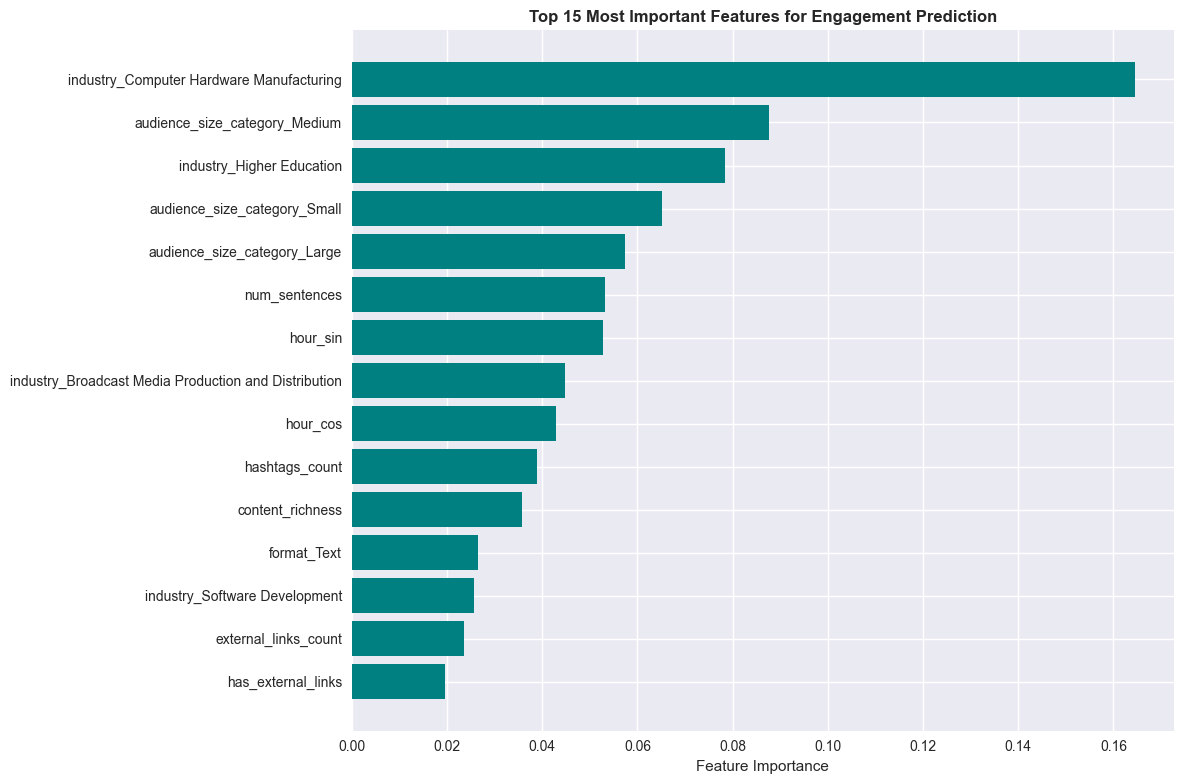

In [85]:
plt.figure(figsize=(12, 8))
top_features = importance_reduced.head(top_n)
plt.barh(range(len(top_features)), top_features['importance'], color='teal')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title(f'Top {top_n} Most Important Features for Engagement Prediction', fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Industry Classification

In [ ]:
# Redefine feature lists for industry classification model (including followers_log)

categorical_features = [
    'format', 'post_day', 'location',
    'audience_size_category', 'content_length_category', 'day_segment'
]

numerical_features = [
    'local_hour', 'followers_log', 'num_sentences', 'hashtags_count',
    'external_links_count', 'total_mentions', 'content_richness',
    'is_weekend', 'is_business_hours', 'hour_sin', 'hour_cos',
    'day_sin', 'day_cos', 'has_hashtags', 'has_external_links', 'has_mentions'
]

features_used = categorical_features + numerical_features

In [87]:
target_col = 'industry'
y = df_ml[target_col].copy()
X = df_ml[features_used].copy()

In [88]:
# Label encoding of industry (y)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [89]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

In [90]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
])

In [91]:
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

In [92]:
cat_ohe = preprocessor.named_transformers_['cat']
cat_ohe_feature_names = cat_ohe.get_feature_names_out(categorical_features)
feature_names = numerical_features + list(cat_ohe_feature_names)

In [93]:
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train_prep, y_train)

GradientBoostingClassifier(random_state=42)

In [94]:
y_pred = gb.predict(X_test_prep)

In [ ]:
# Display classification performance metrics and confusion matrix for industry prediction model

print(classification_report(y_test, y_pred, target_names=le.classes_))
print(confusion_matrix(y_test, y_pred))

                                               precision    recall  f1-score   support

                                   Accounting       1.00      1.00      1.00        66
                    Architecture and Planning       0.75      0.75      0.75         4
               Book and Periodical Publishing       1.00      1.00      1.00        99
  Broadcast Media Production and Distribution       1.00      1.00      1.00       256
             Business Consulting and Services       0.99      0.99      0.99       311
              Business Intelligence Platforms       1.00      1.00      1.00       100
                Business Supplies & Equipment       1.00      1.00      1.00        69
                              Capital Markets       1.00      1.00      1.00        25
               Civic and Social Organizations       1.00      1.00      1.00        83
              Computer Hardware Manufacturing       1.00      1.00      1.00        69
                              Events Servi

**Explanation of the results:**

The industry classification model shows **excellent performance** with 99% accuracy across all industries. Key observations:

- **Overall Performance**: 99% accuracy with nearly perfect precision, recall, and F1-scores
- **Most Industries**: Achieve perfect 1.00 scores across all metrics (precision, recall, F1)
- **Minor Issues**: Only a few industries show slight imperfections:
  - Architecture and Planning: 75% precision/recall (likely due to very small sample size of 4)
  - Investment Management: 95% recall (missing 5% of actual cases)
  - Law Practice: 99% recall (missing 1% of actual cases)

- **Large Industries**: Perform exceptionally well:
  - Financial Services (1,272 samples): 98% precision, 100% recall
  - Software Development (1,075 samples): 99% precision, 100% recall

- **Confusion Matrix**: Shows very clean diagonal pattern with minimal off-diagonal errors, indicating the model rarely misclassifies industries

This suggests that LinkedIn post characteristics (format, timing, content, audience) are highly predictive of the industry, making industry classification a much easier task than engagement prediction.

In [ ]:
# Extract and display feature importance for industry classification model

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': gb.feature_importances_
}).sort_values('importance', ascending=False).reset_index(drop=True)
display(importance_df.head(15))


,feature,importance
0,followers_log,0.805446
1,location_United Kingdom,0.028795
2,location_United States,0.026204
3,location_Singapore,0.023273
4,audience_size_category_Medium,0.019920
5,location_Netherlands,0.010422
6,audience_size_category_Large,0.009816
7,location_France,0.009338
8,location_Cayman Islands,0.008448
9,content_richness,0.007848


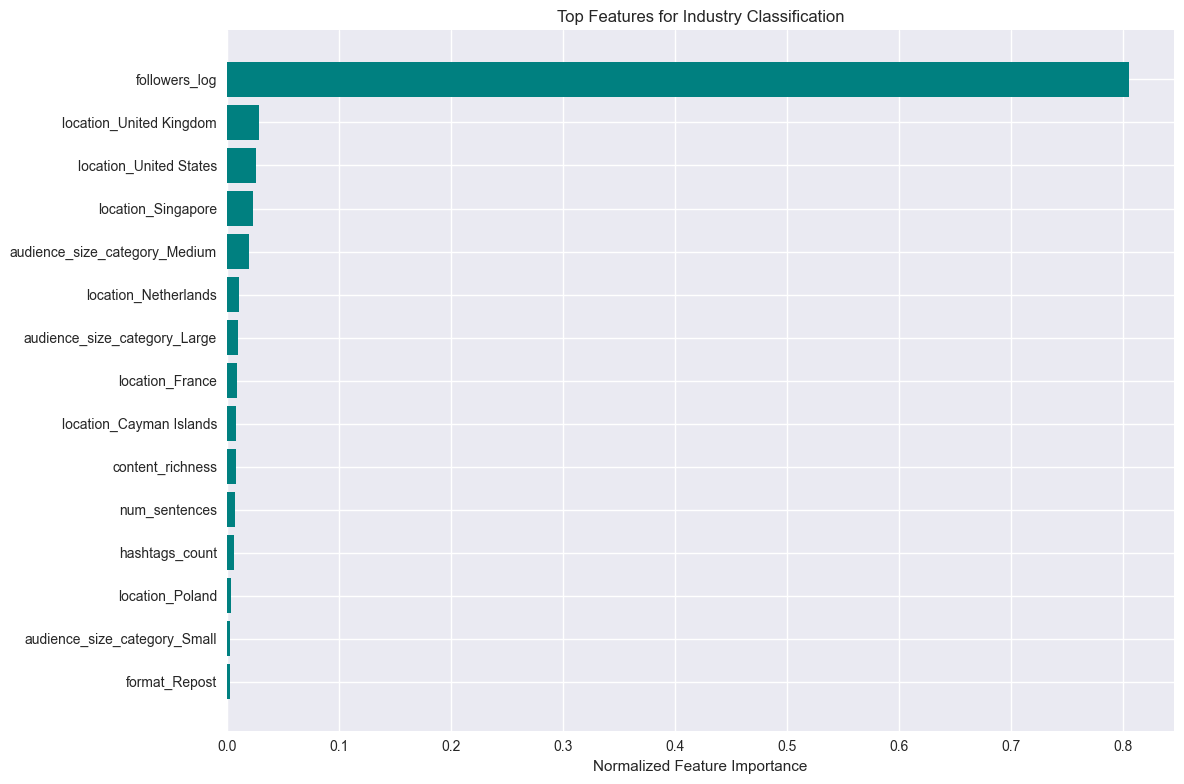

In [99]:
# Normalize importance scores so they sum to 1
importance_df['importance_normalized'] = (
    importance_df['importance'] / importance_df['importance'].sum()
)

# Create horizontal bar chart of top 15 most important features for industry classification
plt.figure(figsize=(12, 8))
top_features = importance_df.head(15)
plt.barh(top_features['feature'], top_features['importance_normalized'], color='teal')
plt.xlabel('Normalized Feature Importance')
plt.title('Top Features for Industry Classification')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## No followers_log

In [100]:
#### Feature engineering ####
categorical_features = [
    'format', 'post_day', 'location',
    'audience_size_category', 'content_length_category', 'day_segment'
]

numerical_features = [
    'local_hour', 'num_sentences', 'hashtags_count',
    'external_links_count', 'total_mentions', 'content_richness',
    'is_weekend', 'is_business_hours', 'hour_sin', 'hour_cos',
    'day_sin', 'day_cos', 'has_hashtags', 'has_external_links', 'has_mentions'
]

features_used = categorical_features + numerical_features

In [101]:
target_col = 'industry'
y = df_ml[target_col].copy()
X = df_ml[features_used].copy()

In [102]:
# Label encoding of industry (y)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [103]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

In [104]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
])

In [105]:
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

In [106]:
cat_ohe = preprocessor.named_transformers_['cat']
cat_ohe_feature_names = cat_ohe.get_feature_names_out(categorical_features)
feature_names = numerical_features + list(cat_ohe_feature_names)

In [ ]:
# Apply SMOTE to balance the training dataset by oversampling minority classes

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_prep, y_train)


**Why SMOTE is needed:**
- In industry classification, some industries might have very few samples compared to others
- Without balancing, the model might perform poorly on underrepresented industries
- SMOTE helps ensure the model learns patterns from all industries equally

In [ ]:
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train_smote, y_train_smote)

In [151]:
y_pred = gb.predict(X_test_prep)

In [ ]:
# Evaluate on original test data to get realistic performance metrics without synthetic data bias

print(classification_report(y_test, y_pred, target_names=le.classes_))
print(confusion_matrix(y_test, y_pred))

                                               precision    recall  f1-score   support

                                   Accounting       0.47      0.11      0.17        66
                    Architecture and Planning       0.75      0.75      0.75         4
               Book and Periodical Publishing       0.62      0.45      0.53        99
  Broadcast Media Production and Distribution       0.67      0.54      0.60       256
             Business Consulting and Services       0.70      0.16      0.26       311
              Business Intelligence Platforms       0.82      0.89      0.86       100
                Business Supplies & Equipment       0.69      0.72      0.71        69
                              Capital Markets       0.38      0.32      0.35        25
               Civic and Social Organizations       0.33      0.29      0.31        83
              Computer Hardware Manufacturing       0.73      0.51      0.60        69
                              Events Servi

**Explanation:** We evaluate on the original test data (not SMOTE-balanced) because:
1. **Real-world representation** - Test data should reflect actual class distribution
2. **Unbiased evaluation** - Avoids inflating performance metrics with synthetic data
3. **Proper validation** - Tests how well the model generalizes to real imbalanced data
4. **Standard practice** - SMOTE is only applied to training data, never to test/validation sets

In [166]:
X_new = pd.DataFrame([{
    'format': 'Video',
    'post_day': 'Friday',
    'location': 'France',
    'audience_size_category': 'Medium',
    'content_length_category': 'Short',
    'day_segment': 'afternoon',
    'local_hour': 14,
    'followers_log': 7.5,
    'num_sentences': 4,
    'hashtags_count': 1,
    'external_links_count': 0,
    'total_mentions': 0,
    'content_richness': 0.3,
    'is_weekend': 0,
    'is_business_hours': 1,
    'hour_sin': 0.5,
    'hour_cos': 0.5,
    'day_sin': 0.2,
    'day_cos': 0.9,
    'has_hashtags': 1,
    'has_external_links': 0,
    'has_mentions': 0,
}])

In [167]:
X_new_prep = preprocessor.transform(X_new)

In [168]:
probs = gb.predict_proba(X_new_prep)[0]
industry_probs = sorted(zip(le.classes_, probs), key=lambda x: x[1], reverse=True)

In [169]:
print("\nRecommendation: top industry probabilities for the sample post:")
for ind, prob in industry_probs[:10]:
    print(f"{ind:45} : {prob:.2%}")


Recommendation: top industry probabilities for the sample post:
Financial Services                            : 59.17%
Software Development                          : 33.68%
Venture Capital and Private Equity Principals : 1.73%
Broadcast Media Production and Distribution   : 1.35%
Media and Telecommunications                  : 0.84%
Business Consulting and Services              : 0.83%
Accounting                                    : 0.71%
Non-profit Organizations                      : 0.42%
Technology, Information and Media             : 0.30%
Utilities                                     : 0.24%


In [153]:
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': gb.feature_importances_
}).sort_values('importance', ascending=False).reset_index(drop=True)
display(importance_df.head(15))

,feature,importance
0,hour_sin,0.110681
1,location_United Kingdom,0.110061
2,audience_size_category_Small,0.088253
3,location_United States,0.078546
4,content_richness,0.074205
5,audience_size_category_Medium,0.071364
6,audience_size_category_Large,0.057606
7,location_Singapore,0.040548
8,num_sentences,0.040348
9,hashtags_count,0.040185


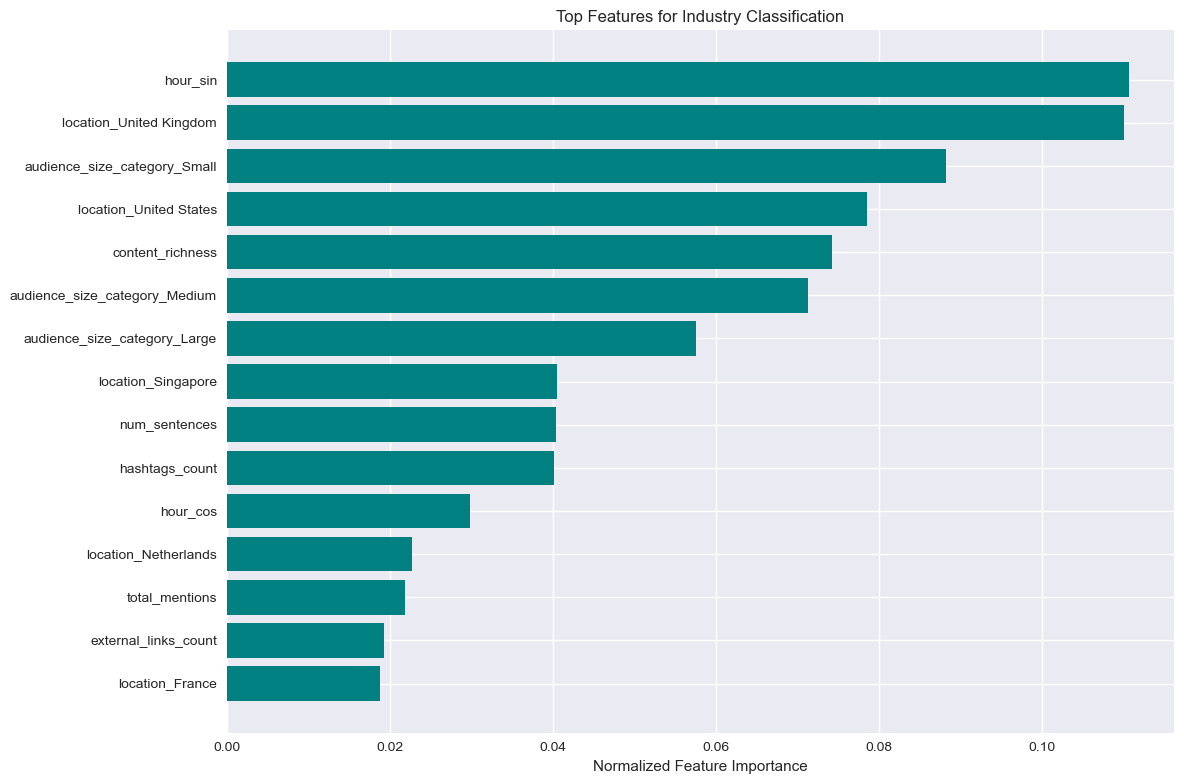

In [154]:
plt.figure(figsize=(12, 8))
top_features = importance_df.head(15)
plt.barh(top_features['feature'], top_features['importance'], color='teal')
plt.xlabel('Normalized Feature Importance')
plt.title('Top Features for Industry Classification')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [155]:
df_industry_stats = df_ml.groupby('industry').agg({
    'engagement_rate': ['mean', 'count'],
    'comments_ratio': ['mean']
}).reset_index()

In [156]:
df_industry_stats.columns = [
    'industry',
    'engagement_rate_mean',
    'engagement_rate_count',
    'comments_ratio_mean'
]

In [157]:
df_industry_stats = df_industry_stats.sort_values('engagement_rate_mean', ascending=False)

In [158]:
display(df_industry_stats.head(10))

,industry,engagement_rate_mean,engagement_rate_count,comments_ratio_mean
1,Architecture and Planning,5.036994,21,0.038184
21,Marketing Services,4.577700,22,0.072845
28,Restaurants,2.317778,116,0.063234
26,Periodical Publishing,1.612903,17,0.098593
15,IT Services and IT Consulting,1.510114,515,0.027831
7,Capital Markets,1.503984,125,0.038068
32,"Technology, Information and Internet",1.502994,900,0.056298
16,Insurance,1.233670,317,0.030216
18,Investment Management,0.949331,280,0.023981
4,Business Consulting and Services,0.801581,1552,0.024736


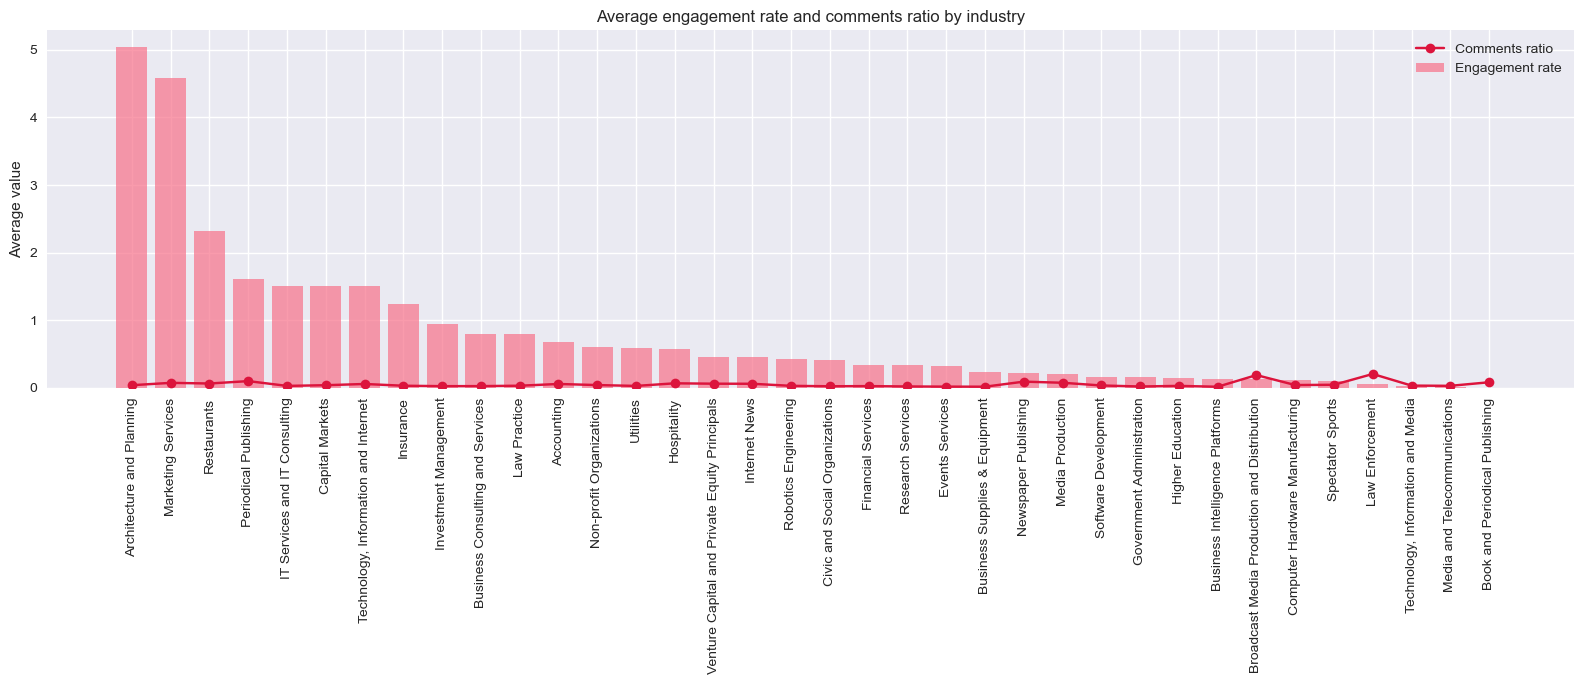

In [159]:
plt.figure(figsize=(16, 7))
plt.bar(df_industry_stats['industry'], df_industry_stats['engagement_rate_mean'], alpha=0.7, label='Engagement rate')
plt.plot(df_industry_stats['industry'], df_industry_stats['comments_ratio_mean'], color='crimson', marker='o', label='Comments ratio')
plt.xticks(rotation=90)
plt.ylabel('Average value')
plt.title('Average engagement rate and comments ratio by industry')
plt.legend()
plt.tight_layout()
plt.show()

# K-Means

In [171]:
user_features = [
    'followers_log', 'location', 'industry', 'audience_size_category'
]

In [172]:
user_df = df_ml[user_features].copy()

In [173]:
user_cat_features = ['location', 'industry', 'audience_size_category']
user_num_features = ['followers_log']
user_preprocessor = ColumnTransformer([
    ('num', StandardScaler(), user_num_features),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), user_cat_features)
])
user_matrix = user_preprocessor.fit_transform(user_df)

In [174]:
post_features = [
    'format', 'content_length_category', 'num_sentences', 'hashtags_count',
    'external_links_count', 'total_mentions', 'content_richness', 'is_weekend', 'is_business_hours'
]

In [175]:
post_df = df_ml[post_features].copy()
post_cat_features = ['format', 'content_length_category']
post_num_features = [f for f in post_features if f not in post_cat_features]
post_preprocessor = ColumnTransformer([
    ('num', StandardScaler(), post_num_features),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), post_cat_features)
])
post_matrix = post_preprocessor.fit_transform(post_df)

In [176]:
def elbow_plot(matrix, max_k=15, title="Elbow - Optimal k"):
    inertia = []
    k_range = range(1, max_k+1)
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(matrix)
        inertia.append(kmeans.inertia_)
    plt.figure(figsize=(8,4))
    plt.plot(k_range, inertia, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Within-cluster SSE (inertia)')
    plt.title(title)
    plt.grid(True)
    plt.show()


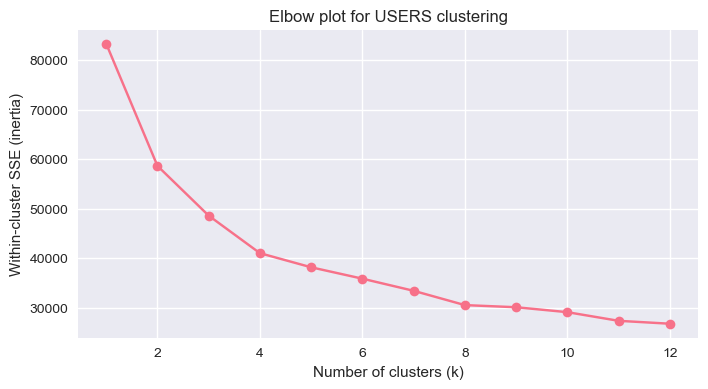

In [177]:
elbow_plot(user_matrix, max_k=12, title="Elbow plot for USERS clustering")

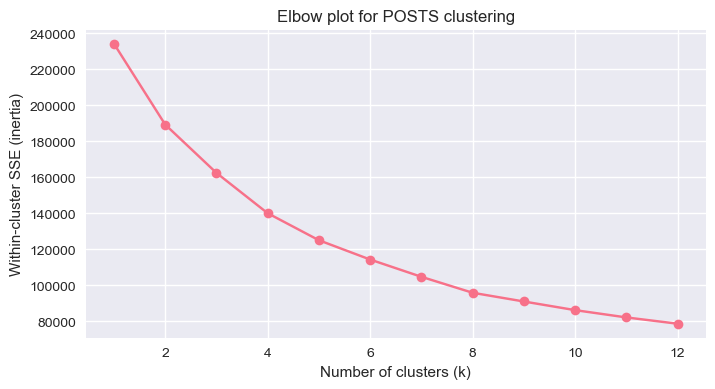

In [178]:
elbow_plot(post_matrix, max_k=12, title="Elbow plot for POSTS clustering")

In [179]:
k_users = 4
k_posts = 5

In [180]:
user_kmeans = KMeans(n_clusters=k_users, random_state=42, n_init=10)
user_labels = user_kmeans.fit_predict(user_matrix)
user_df['cluster'] = user_labels

In [181]:
post_kmeans = KMeans(n_clusters=k_posts, random_state=42, n_init=10)
post_labels = post_kmeans.fit_predict(post_matrix)
post_df['cluster'] = post_labels

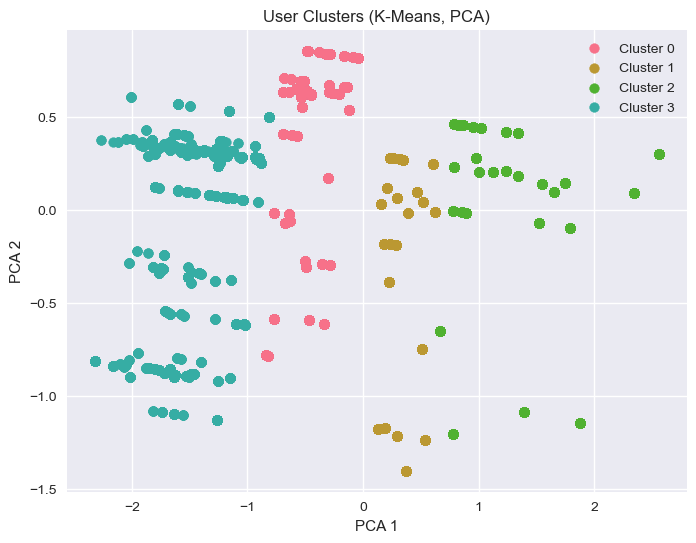

In [183]:
pca = PCA(n_components=2)
user_matrix_2d = pca.fit_transform(user_matrix)
plt.figure(figsize=(8,6))
for k in range(k_users):
    plt.scatter(user_matrix_2d[user_df['cluster']==k, 0], user_matrix_2d[user_df['cluster']==k, 1], label=f'Cluster {k}')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('User Clusters (K-Means, PCA)')
plt.legend()
plt.show()

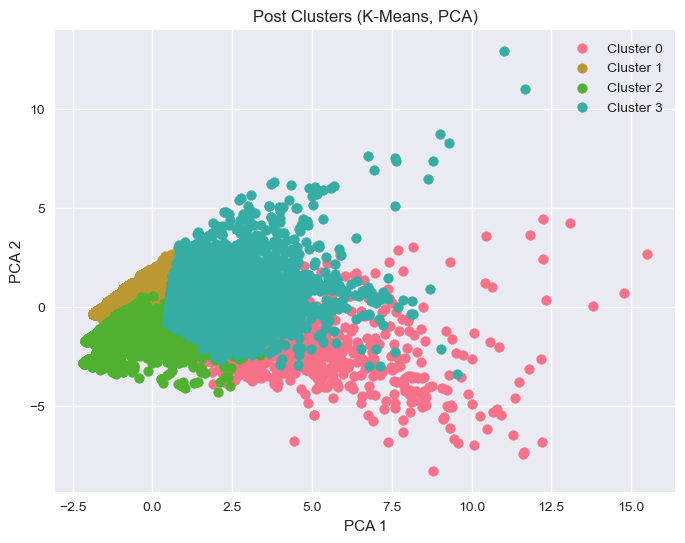

In [184]:
pca = PCA(n_components=2)
post_matrix_2d = pca.fit_transform(post_matrix)
plt.figure(figsize=(8,6))
for k in range(k_users):
    plt.scatter(post_matrix_2d[post_df['cluster']==k, 0], post_matrix_2d[post_df['cluster']==k, 1], label=f'Cluster {k}')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Post Clusters (K-Means, PCA)')
plt.legend()
plt.show()

In [185]:
post_cluster_profile = post_df.groupby('cluster').mean(numeric_only=True)
print(post_cluster_profile)

         num_sentences  hashtags_count  external_links_count  total_mentions  \
cluster                                                                        
0             9.532189        3.729614              0.795064       15.921674   
1             4.853161        0.844581              0.622102        1.095357   
2             4.676958        1.098342              0.602058        0.855918   
3             8.653913        6.364889              1.334062        2.589637   
4             4.747225        1.029659              0.625718        1.122465   

         content_richness  is_weekend  is_business_hours  
cluster                                                   
0               20.446352    0.023605           0.739270  
1                2.562040    0.000000           1.000000  
2                2.556318    1.000000           0.627216  
3               10.288588    0.015741           0.874508  
4                2.777842    0.000000           0.000000  


In [186]:
format_dist = post_df.groupby('cluster')['format'].value_counts(normalize=True)
print(format_dist)

cluster  format      
0        Image           0.335837
         Text            0.275751
         Repost          0.252146
         Document        0.047210
         Video           0.040773
         Article         0.038627
         Feed Sharing    0.009657
1        Image           0.402848
         Video           0.152863
         Article         0.149760
         Text            0.128948
         Repost          0.086533
         Document        0.047405
         Feed Sharing    0.026836
         Poll            0.004807
2        Image           0.378502
         Article         0.243568
         Video           0.129788
         Text            0.110349
         Repost          0.060606
         Feed Sharing    0.040595
         Document        0.035449
         Poll            0.001144
3        Image           0.467206
         Text            0.155007
         Article         0.138391
         Video           0.099694
         Repost          0.093354
         Document        0

In [187]:
audience_dist = user_df.groupby('cluster')['audience_size_category'].value_counts(normalize=True)
print(audience_dist)

cluster  audience_size_category
0        Medium                    1.0
         Small                     0.0
         Large                     0.0
         Enterprise                0.0
1        Large                     1.0
         Small                     0.0
         Medium                    0.0
         Enterprise                0.0
2        Enterprise                1.0
         Small                     0.0
         Medium                    0.0
         Large                     0.0
3        Small                     1.0
         Medium                    0.0
         Large                     0.0
         Enterprise                0.0
Name: proportion, dtype: float64


In [188]:
print(post_df['cluster'].value_counts())
print(user_df['cluster'].value_counts())

cluster
1    16433
4     5226
3     4574
2     1749
0      932
Name: count, dtype: int64
cluster
0    8519
2    8165
3    6782
1    5448
Name: count, dtype: int64


In [191]:
def find_typical(df, matrix, kmeans, feature_cols):
    typical = []
    for k in range(kmeans.n_clusters):
        cluster_idx = np.where(df['cluster']==k)[0]
        distances = distance.cdist(matrix[cluster_idx], [kmeans.cluster_centers_[k]], 'euclidean')
        typical_idx = cluster_idx[np.argmin(distances)]
        typical.append(df.iloc[typical_idx][feature_cols])
    return pd.DataFrame(typical)

In [192]:
typical_posts = find_typical(post_df, post_matrix, post_kmeans, post_features)
print(typical_posts)

        format content_length_category  num_sentences  hashtags_count  \
19728    Image                    Long              8               4   
9641   Article                  Medium              5               1   
9654   Article                  Medium              5               1   
2058   Article                    Long              9               6   
29227  Article                  Medium              5               1   

       external_links_count  total_mentions  content_richness  is_weekend  \
19728                     1              16                21           0   
9641                      1               1                 3           0   
9654                      1               0                 2           1   
2058                      1               3                10           0   
29227                     1               1                 3           0   

       is_business_hours  
19728                  1  
9641                   1  
9654             